<a href="https://colab.research.google.com/github/fatday/STATS-305B-HW4-Group/blob/main/Part2_Working.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part 2 Code Set up

In [ ]:
# torch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import math

import matplotlib.pyplot as plt
from tqdm import tqdm
import requests
import os
import json
import re
from collections import Counter
import sentencepiece as spm

torch.manual_seed(305)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
import numpy as np

We set default values for some global hyperparameters, but feel free to change these during development as needed.

In [ ]:
# Global hyperparameters
SMALL_ITERS = 1000
LARGE_ITERS = 2000
EVAL_ITERS = 100
CONTEXT_WINDOW_SIZE = 256

## Preprocessing

In [ ]:
# download the tiny shakespeare dataset
input_file_path = 'input.txt'

if not os.path.exists(input_file_path):
    data_url = 'https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt'
    with open(input_file_path, 'w') as f:
        f.write(requests.get(data_url).text)

with open(input_file_path, 'r') as f:
    data = f.read()
print(f"length of dataset in characters: {len(data):,}")

length of dataset in characters: 1,115,394


## Tokenizer and its Sub-Classes

In [ ]:
class Tokenizer:
    def __init__(self, data):
        self.data = data
        self.stoi = {}
        self.itos = {}
        self.vocab_size = 0
        self.train_data = None
        self.val_data = None

    def encode(self, s):
        return [self.stoi[c] for c in s]

    def decode(self, l):
        return ''.join([self.itos[i] for i in l])


    def get_batch(self, split, context_window_size, device, batch_size=32):

        current_data = self.train_data if split == 'train' else self.val_data
        ix = torch.randint(len(current_data) - context_window_size, (batch_size,))
        x = torch.stack([current_data[i:i+context_window_size] for i in ix])
        y = torch.stack([current_data[i+1:i+context_window_size+1] for i in ix])
        x = x.to(device)
        y = y.to(device)
        return x, y

    @torch.no_grad()
    def estimate_loss(self, model, eval_iters, context_window_size, device):
        # estimate loss, perplexity, character_level perplexity
        model.eval()
        lossout, perplexity, char_perplexity = {}, {}, {}
        for split in ['train', 'val']:
            losses = torch.zeros(eval_iters)
            perplexities = torch.zeros(eval_iters)
            ppl_acc = 0
            for k in range(eval_iters):
                X, Y = self.get_batch(split, context_window_size, device)
                logits, loss = model(X, Y)
                losses[k] = loss.item()
                perplexities[k] = torch.exp(loss).item()
                avg_c_pt = len(self.decode(Y[0].tolist())) / len(Y[0].tolist())
                ppl_acc += perplexities[k]**(1.0/avg_c_pt)

            char_perplexity[split] = ppl_acc / eval_iters
            lossout[split] = losses.mean()
            perplexity[split] = perplexities.mean()
        model.train()
        return lossout, perplexity, char_perplexity


In [ ]:
class CharacterTokenizer(Tokenizer):
    def __init__(self, data):
        self.data = data
        self.chars = sorted(list(set(data)))
        self.vocab_size = len(self.chars)

        self.train_chars = data[:int(len(data)*0.9)]
        self.val_chars = data[int(len(data)*0.9):]

        self.stoi = { ch:i for i,ch in enumerate(self.chars) }
        self.itos = { i:ch for i,ch in enumerate(self.chars) }

        self.train_data = torch.tensor(self.encode(self.train_chars))
        self.val_data = torch.tensor(self.encode(self.val_chars))

In [ ]:
class SimpleWordTokenizer(Tokenizer):
    def __init__(self, data):
        self.data = data
        self.data_words = re.findall(r'\w+|\s+|[^\w\s]', data)
        self.vocab_set = set(self.data_words).union(set(data))
        self.vocab_size = len(self.vocab_set)

        self.stoi = {ch:i for i,ch in enumerate(self.vocab_set)}
        self.itos = {i:ch for i,ch in enumerate(self.vocab_set)}

        self.train_words = self.data_words[:int(len(self.data_words)*0.9)]
        self.val_words = self.data_words[int(len(self.data_words)*0.9):]

        self.train_data = torch.tensor(self.encode(self.train_words))
        self.val_data = torch.tensor(self.encode(self.val_words))

In [ ]:
class BPETokenizer(Tokenizer):
    def __init__(self, data):
        self.data = data
        # BPE
        spm.SentencePieceTrainer.Train(input="input.txt",
        model_prefix="tokenizer",
        vocab_size=3000,
        model_type="bpe",
        normalization_rule_name="identity",
        character_coverage=1.0,
        add_dummy_prefix=False,
        user_defined_symbols = ['\n', ' ', '!', '$', '&', "'", ',', '-', '.', '3', ':', ';', '?'])

        self.sp = spm.SentencePieceProcessor(model_file="tokenizer.model")
        self.vocab_size = self.sp.vocab_size()


        self.train_chars = data[:int(len(data)*0.9)]
        self.val_chars = data[int(len(data)*0.9):]
        self.train_data = torch.tensor(self.encode(self.train_chars))
        self.val_data = torch.tensor(self.encode(self.val_chars))

    def encode(self, s):
      return self.sp.encode(s, out_type=int)

    def decode(self, l):
      return self.sp.decode(l)

## Original Head

In [ ]:
class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size, context_window_size, embed_size=384):
        """
        Args:
          head_size: int, size of the head embedding dimension (K)
          context_window_size: int, number of tokens considered in the past for attention (T)
          embed_size: int, size of the token embedding dimension (D)
        """
        super().__init__()
        self.head_size = head_size
        self.key = nn.Linear(embed_size, head_size, bias=False)
        self.query = nn.Linear(embed_size, head_size, bias=False)
        self.value = nn.Linear(embed_size, embed_size, bias=False)

        # not a param of the model, so registered as a buffer
        self.register_buffer('tril', torch.tril(
            torch.ones(context_window_size, context_window_size)))

    def forward(self, x):
        """
        Args:
          x: (B,T,D) tensor of token embeddings

        Returns:
          (B,T,D) tensor of attention-weighted token embeddings
        """
        # TODO: your code here
        B,T,D = x.shape
        k = self.key(x)
        q = self.query(x)
        v = self.value(x)
        wei = q @ k.transpose(-2,-1) * self.head_size**-0.5
        #tril = torch.tril(torch.ones(T, T, device=x.device))
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        wei = F.softmax(wei, dim=-1)  ## wei.shape:
        out = wei @ v
        return out

In [ ]:
class SingleHeadedAttentionLM(nn.Module):

    def __init__(self, vocab_size, context_window_size, head_size, embed_size=384):
      """
      Args:
        vocab_size: int, size of the vocabulary (V)
        context_window_size: int, number of tokens considered in the past for attention (T)
        head_size: int, size of the head embedding dimension (K)
        embed_size: int, size of the token embedding dimension (D)
      """
      super().__init__()
      self.token_embedding_table = nn.Embedding(vocab_size, embed_size)
      self.position_embedding_table = nn.Embedding(context_window_size, embed_size)
      self.context_window_size = context_window_size

      # TODO: your code below
      self.atten_head = Head(head_size, context_window_size)
      self.lm_head = nn.Linear(embed_size, vocab_size)
      self.context_window_size = context_window_size

    def forward(self, token_ids, targets=None):
        """
        Args:
          token_ids: (B, T) token ids that make up the context (batch has size B, each entry
                     in the batch has length T)
          targets: (B, T) token ids corresponding to the target of each context in token_ids

        Returns:
          logits: (B, T, V) logits[b,t] gives the length V vector of logits for the next token
                   prediction in string b up to t tokens
          loss: scalar, negative log likelihood of target given context
        """
        B, T = token_ids.shape # (batch size, length)
        tok_emb = self.token_embedding_table(token_ids) # (B,T,D)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,D)
        x = tok_emb + pos_emb # (B,T,D)
        x = self.atten_head(x) # (B,T,D)
        logits = self.lm_head(x) # (B,T,V)

        # TODO: your code here
        B, T, V = logits.shape
        logits = logits.view(B*T, V)
        if targets is None:
            loss = None
        else:
            targets = targets.view(B*T)
            loss = -torch.mean(torch.log(F.softmax(logits, dim=1)[torch.arange(B*T), targets]))
        return logits, loss

    @torch.no_grad()
    def generate(self, token_ids, max_new_tokens):
        """
        Args:
          token_ids: (B, T) tensor of token ids to provide as context
          max_new_tokens: int, maximum number of new tokens to generate

        Returns:
          (B, T+max_new_tokens) tensor of context with new tokens appended
        """
        #TODO
        # your code below
        B, T = token_ids.shape
        new_token_sequences = torch.zeros((B, T+max_new_tokens), dtype=torch.long, device=token_ids.device)
        new_token_sequences[:, :T] = token_ids
        for t in range(max_new_tokens):
          input_tokens = new_token_sequences[:, max(0, T + t - self.context_window_size): T + t]
          logits, loss = self(input_tokens)
          logits = logits.view(B, min(T + t, self.context_window_size), -1)
          logits = logits[:, -1, :]
          probs = F.softmax(logits, dim=-1)
          new_token = torch.multinomial(probs, num_samples=1)
          new_token_sequences[:, T + t] = new_token.squeeze(-1)
        return new_token_sequences

In [ ]:

class MultiHeadAttention(nn.Module):
    def __init__(self, context_window_size, num_heads, embed_size):
        super().__init__()
        self.num_heads = num_heads
        self.head_size = embed_size // num_heads  # 确保总维度匹配

        self.heads = nn.ModuleList(
            [Head(self.head_size, context_window_size, embed_size) for _ in range(num_heads)]
        )
        self.proj = nn.Linear(embed_size * num_heads, embed_size)  # 确保总维度匹配
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)  # 拼接 heads

        out = self.dropout(self.proj(out))  # 投影回 embed_size
        return out


In [ ]:
class MultiHeadedAttentionLM(nn.Module):

    def __init__(self, vocab_size, context_window_size, embed_size=384, num_heads=6):
      super().__init__()
      self.head_size = embed_size // num_heads
      self.context_window_size = context_window_size
      # TODO: your code below
      self.token_embedding_table = nn.Embedding(vocab_size, embed_size)
      self.position_embedding_table = nn.Embedding(context_window_size, embed_size)
      self.atten_heads = MultiHeadAttention(context_window_size, num_heads, embed_size)
      self.lm_head = nn.Linear(embed_size, vocab_size)


    def forward(self, token_ids, targets=None):
        """
        Args:
          token_ids: (B, T) token ids that make up the context (batch has size B, each entry in the
                     batch has length T)
          targets: (B, T) token ids corresponding to the target of each context in token_ids

        Returns:
          logits: (B, T, V), logits[b,t] gives the length V vector of logits for the next token
                  prediction in string b up to t tokens
          loss: scalar, negative log likelihood of target given context
        """
        # TODO: your code below
        B, T = token_ids.shape
        tok_emb = self.token_embedding_table(token_ids)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device))
        x = tok_emb + pos_emb
        x = self.atten_heads(x)
        logits = self.lm_head(x)
        if targets is None:
            loss = None
        else:
            logits = logits.view(B*T, -1)
            targets = targets.view(B*T)
            loss = -torch.mean(torch.log(F.softmax(logits, dim=1)[torch.arange(B*T), targets]))

        return logits, loss

    @torch.no_grad()
    def generate(self, token_ids, max_new_tokens):
        """
        Args:
          token_ids: (B, T) tensor of token ids to provide as context
          max_new_tokens: int, maximum number of new tokens to generate

        Returns:
          (B, T+max_new_tokens) tensor of context with new tokens appended
        """
        # TODO: your code below
        B, T = token_ids.shape
        new_token_sequences = torch.zeros((B, T+max_new_tokens), dtype=torch.long, device=token_ids.device)
        new_token_sequences[:, :T] = token_ids
        for t in range(max_new_tokens):
          input_tokens = new_token_sequences[:, max(0, T + t - self.context_window_size): T + t]
          logits, loss = self(input_tokens)
          logits = logits.view(B,min(T + t, self.context_window_size), -1)
          logits = logits[:, -1, :]
          probs = F.softmax(logits, dim=-1)
          new_token = torch.multinomial(probs, num_samples=1)
          new_token_sequences[:, T + t] = new_token.squeeze(-1)
        return new_token_sequences

## RoE Head

In [ ]:
class RotaryEmbedding(nn.Module):
    def __init__(self, dim, max_position_embeddings=2048):
        super().__init__()
        inv_freq = 1.0 / (10000 ** (torch.arange(0, dim, 2).float() / dim))
        self.register_buffer('inv_freq', inv_freq)
        self.max_seq_len_cached = max_position_embeddings
        self._set_cos_sin_cache(max_position_embeddings)

    def _set_cos_sin_cache(self, seq_len):
        t = torch.arange(seq_len, device=self.inv_freq.device)
        freqs = torch.einsum('i,j->ij', t, self.inv_freq)
        emb = torch.cat((freqs, freqs), dim=-1)
        self.register_buffer('cos_cached', emb.cos()[None, None, :, :])
        self.register_buffer('sin_cached', emb.sin()[None, None, :, :])
        self.max_seq_len_cached = seq_len

    def forward(self, x, seq_len=None):
        # x: [batch, seq_len, dim]
        if seq_len > self.max_seq_len_cached:
            self._set_cos_sin_cache(seq_len)
        return self.cos_cached[:, :, :seq_len, ...], self.sin_cached[:, :, :seq_len, ...]

def rotate_half(x):
    x1, x2 = x[..., :x.shape[-1]//2], x[..., x.shape[-1]//2:]
    return torch.cat((-x2, x1), dim=-1)

def apply_rotary_pos_emb(q, k, cos, sin):
    q_embed = (q * cos) + (rotate_half(q) * sin)
    k_embed = (k * cos) + (rotate_half(k) * sin)
    return q_embed, k_embed

# Modify the Head class to use RoPE
class HeadWithRoPE(nn.Module):
    def __init__(self, head_size, context_window_size, embed_size=384):
        super().__init__()
        self.head_size = head_size
        self.key = nn.Linear(embed_size, head_size, bias=False)
        self.query = nn.Linear(embed_size, head_size, bias=False)
        self.value = nn.Linear(embed_size, embed_size, bias=False)
        self.rope = RotaryEmbedding(head_size)
        self.register_buffer('tril', torch.tril(torch.ones(context_window_size, context_window_size)))

    def forward(self, x):
        B, T, D = x.shape
        k = self.key(x)
        q = self.query(x)
        v = self.value(x)

        # Apply RoPE to queries and keys
        cos, sin = self.rope(x, seq_len=T)
        q, k = apply_rotary_pos_emb(q, k, cos, sin)

        # Rest of the attention mechanism remains the same
        wei = q @ k.transpose(-2, -1) * self.head_size**-0.5
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        wei = F.softmax(wei, dim=-1)
        out = wei @ v
        return out

In [ ]:
class MultiHeadAttentionWithRoPE(nn.Module):
    def __init__(self, context_window_size, num_heads, embed_size):
        super().__init__()
        self.num_heads = num_heads
        self.head_size = embed_size // num_heads

        # QKV projections
        self.q_proj = nn.Linear(embed_size, embed_size, bias=False)
        self.k_proj = nn.Linear(embed_size, embed_size, bias=False)
        self.v_proj = nn.Linear(embed_size, embed_size, bias=False)
        self.out_proj = nn.Linear(embed_size, embed_size)

        # RoPE
        self.rope = RotaryEmbedding(self.head_size)
        # Causal mask
        self.register_buffer('mask', torch.tril(torch.ones(context_window_size, context_window_size)))

        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        B, T, D = x.shape

        # Split heads
        q = self.q_proj(x).view(B, T, self.num_heads, self.head_size).transpose(1, 2)
        k = self.k_proj(x).view(B, T, self.num_heads, self.head_size).transpose(1, 2)
        v = self.v_proj(x).view(B, T, self.num_heads, self.head_size).transpose(1, 2)

        # Apply RoPE to queries and keys
        cos, sin = self.rope(x, seq_len=T)
        q, k = apply_rotary_pos_emb(q, k, cos, sin)

        # Attention
        scores = (q @ k.transpose(-2, -1)) / math.sqrt(self.head_size)
        scores = scores.masked_fill(self.mask[:T, :T] == 0, float('-inf'))
        attn = F.softmax(scores, dim=-1)
        attn = self.dropout(attn)

        # Combine heads
        out = (attn @ v).transpose(1, 2).contiguous().view(B, T, D)
        out = self.out_proj(out)
        return out

In [ ]:
# run this cell to initialize this deep learning module that you should use in the code your write later
# you don't need to edit this layer
class FeedForward(nn.Module):
    """ a simple linear layer followed by a non-linearity
        Given to you, you don't need to write any code here!
    """

    def __init__(self, embed_size, gelu = False, dropout = False):
        super().__init__()


        self.activation = nn.GELU() if gelu else nn.ReLU()
        layers = [nn.Linear(embed_size, 4 * embed_size), self.activation]
        if dropout:
            layers.append(nn.Dropout(0.1))

        layers.append(nn.Linear(4 * embed_size, embed_size))
        if dropout:
            layers.append(nn.Dropout(0.1))

        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

## Transformer and Blocks

In [ ]:
class TransformerBlock(nn.Module):
    """ Transformer block: communication across sequence length, followed by communication across embedding space
        Uses multi-headed attention
    """

    def __init__(self, vocab_size, context_window_size, embed_size=384, num_heads=6, roe = False,
                  gelu = False, dropout = False, rmsnorm = False):
        super().__init__()
        self.ln1 = nn.RMSNorm(embed_size) if rmsnorm else nn.LayerNorm(embed_size)
        self.ln2 = nn.RMSNorm(embed_size) if rmsnorm else nn.LayerNorm(embed_size)

        # TODO: your code below
        self.feed_forward = FeedForward(embed_size, gelu = gelu, dropout = dropout)
        self.atten_heads = MultiHeadAttentionWithRoPE(context_window_size, num_heads, embed_size) if roe else MultiHeadAttention(context_window_size, num_heads, embed_size)

    def forward(self, x):
        x = x + self.atten_heads(self.ln1(x)) # communication over sequence length
        x = x + self.feed_forward(self.ln2(x)) # communication across embedding space
        return x

In [ ]:
class TransformerLM(nn.Module):

    def __init__(self, vocab_size, context_window_size, embed_size=384, num_heads=6, n_layers=6,
                 roe = False, gelu = False, dropout = False, rmsnorm = False):
        """
          Args:
              vocab_size: int, number of tokens in the vocabulary (V)
              context_window_size: int, size of the context window (T)
              embed_size: int, embedding size (D)
              num_heads: int, number of heads (H)
              n_layers: int, number of layers (M)
        """
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, embed_size)
        if not roe:
          self.position_embedding_table = nn.Embedding(context_window_size, embed_size)
        self.blocks = nn.Sequential(*[
            TransformerBlock(vocab_size,
                             context_window_size,
                             embed_size=embed_size,
                             num_heads=num_heads,
                             roe = roe,
                             gelu= gelu,
                             dropout = dropout,
                             rmsnorm = rmsnorm)
            for _ in range(n_layers)])

        # final layer norm
        self.ln_f = nn.RMSNorm(embed_size) if rmsnorm else nn.LayerNorm(embed_size)
        self.lm_head = nn.Linear(embed_size, vocab_size)
        self.context_window_size = context_window_size
        self.roe = roe
        self.gelu = gelu
        self.dropout = dropout
        self.rmsnorm = rmsnorm
        # good initialization
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, token_ids, targets=None):
        """
        Agrgs:
            token_ids: tensor of integers, provides the contet, shape (B, T)
            targets: tensor of integers, provides the tokens we are preidcitng, shape (B, T)
        """
        B, T = token_ids.shape

        # token_ids and targets are both (B, T) tensor of integers
        tok_emb = self.token_embedding_table(token_ids) # (B, T, D)
        if not self.roe:
          pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T, D)
          x = tok_emb + pos_emb # (B, T, D)
        else:
          x = tok_emb

        # TODO: your code below
        logits = ...
        loss = ...

        x = self.blocks(x)
        x = self.ln_f(x)
        logits = self.lm_head(x)

        B, T, V = logits.shape
        logits = logits.view(B*T, V)

        if targets is None:
            loss = None
        else:
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    @torch.no_grad()
    def generate(self, token_ids, max_new_tokens):
        """
        Args:
            token_ids: tensor of integers forming the context, shape (B, T)
            max_new_tokens: int, max number of tokens to generate
        """
        # TOOD, your code below
        B, T = token_ids.shape
        new_token_sequences = torch.zeros((B, T+max_new_tokens), dtype=torch.long, device=token_ids.device)
        new_token_sequences[:, :T] = token_ids
        for t in range(max_new_tokens):
            input_tokens = new_token_sequences[:, max(0,T + t - self.context_window_size):T + t]
            logits, loss = self(input_tokens)
            logits = logits.view(B,min(T + t, self.context_window_size), -1)
            logits = logits[:, -1, :] # (B, V)
            probs = F.softmax(logits, dim=-1) # (B, V)
            new_token = torch.multinomial(probs, num_samples=1) # (B, 1)
            new_token_sequences[:, T + t] = new_token.squeeze(-1) # (B, T+1)
        return new_token_sequences

## Model & Tokenizer System -- (model, tokenizer) pair

For model training and text generation

In [ ]:
class ModelTokenizerSystem:
  def __init__(self, model, tokenizer, device, optimizer_lr = 1e-4,
               optimizer_weight_decay = 1e-2, model_name = "None"):
    self.model = model
    self.tokenizer = tokenizer
    self.device = device
    self.optimizer = torch.optim.AdamW(model.parameters(),
                                       lr=optimizer_lr,
                                       weight_decay=optimizer_weight_decay)
    self.model_name = model_name
    self.weight_decay = optimizer_weight_decay

  def train(self, lr = 1e-3, eval_interval = 50, display_interval = 200,
            max_iter = 2000, early_stopping = True, min_delta = 0.001, verbose = True ):

    best_score = None
    self.loss_list = []
    self.losses_train_val = {"train": [], "val": []}
    self.perplexities_train_val = {"train": [], "val": []}
    self.char_perplexities_train_val = {"train": [], "val": []}
    for it in tqdm(range(max_iter)):
      if verbose and (it % eval_interval == 0 or it == max_iter - 1):
        losses, perplexity, char_perplexity = self.tokenizer.estimate_loss(self.model, EVAL_ITERS, self.model.context_window_size, self.device)
        if best_score is None:
          best_score = losses["val"]
        self.losses_train_val["train"].append(losses["train"].item())
        self.losses_train_val["val"].append(losses["val"].item())
        self.perplexities_train_val["train"].append(perplexity["train"].item())
        self.perplexities_train_val["val"].append(perplexity["val"].item())
        self.char_perplexities_train_val["train"].append(char_perplexity["train"].item())
        self.char_perplexities_train_val["val"].append(char_perplexity["val"].item())

        if it > 10 and early_stopping and abs(losses["val"] - best_score) < min_delta:
          print(f"Early Stopping Triggered at iteration {it}")
          break
        else:
          best_score = losses["val"]

      if verbose and (it % display_interval == 0 or it == max_iter - 1):
        print(f"iteration {it}")
        train_loss, val_loss = self.losses_train_val["train"][-1], self.losses_train_val["val"][-1]
        print(f"step {it}: train loss {train_loss:.4f}, val loss {val_loss:.4f}")

      xb, yb = self.tokenizer.get_batch('train', self.model.context_window_size, self.device)
      logits, loss = self.model(xb, yb)
      self.loss_list.append(loss.detach().item())
      self.optimizer.zero_grad(set_to_none=True)
      loss.backward()
      self.optimizer.step()


  def save_model_data(self):
    folder_name = self.model_name

    if self.model.roe:
      folder_name += "_RoE"

    if self.model.rmsnorm:
      folder_name += "_RMSNorm"

    if self.model.gelu:
      folder_name += "_GELU"

    if self.model.dropout:
      folder_name += "_Dropout"

    if self.weight_decay != 0:
      folder_name += f"_wd{self.weight_decay}"

    os.makedirs(folder_name, exist_ok=True)
    model_path = os.path.join(folder_name, "model.pth")
    torch.save(self.model.state_dict(), model_path)
    print(f"Model saved to {model_path}")

    data = {
        "loss_list": self.loss_list,
        "losses_train_val": self.losses_train_val,
        "perplexities_train_val": self.perplexities_train_val,
        "char_perplexities_train_val": self.char_perplexities_train_val
    }
    data_path = os.path.join(folder_name, self.model_name+".json")
    with open(data_path, "w") as f:
        json.dump(data, f, indent=4)

    print(f"Training data saved to {data_path}")


  def generate(self, context: str, max_new_tokens = 256) -> str:
    # given string, return out the prediction (input string included)
    context_tokens = torch.tensor(self.tokenizer.encode(context), device=self.device).reshape(1, -1)
    output_tokens = self.model.generate(context_tokens, max_new_tokens)[0].tolist()
    output_context = self.tokenizer.decode(output_tokens)
    return output_context


## Part 2 Model Training

# Test Content

In [ ]:
input_text1 = """
First Citizen:
Care for us! True, indeed! They ne'er cared for us
yet: suffer us to famish, and their store-houses
crammed with grain; make edicts for usury, to
support usurers; repeal daily any wholesome act
established against the rich, and provide more
piercing statutes daily, to chain up and restrain
the poor. If the wars eat us not up, they will; and
there's all the love they bear us.
"""

target_output1 = """
MENENIUS: Either you must
Confess yourselves wondrous malicious,
Or be accused of folly. I shall tell you
A pretty tale: it may be you have heard it;
But, since it serves my purpose, I will venture
To stale 't a little more.
"""

In [ ]:
input_text2 = """MIRANDA:
Why speaks my father so ungently? This
Is the third man that e'er I saw, the first
That e'er I sigh'd for: pity move my father
To be inclined my way!

FERDINAND:
O, if a virgin,
And your affection not gone forth, I'll make you
The queen of Naples.
"""

target_output2 = """PROSPERO:
Soft, sir! one word more.
They are both in either's powers; but this swift business
I must uneasy make, lest too light winning
Make the prize light.
One word more; I charge thee
That thou attend me: thou dost here usurp
The name thou owest not; and hast put thyself
Upon this island as a spy, to win it
From me, the lord on't.

FERDINAND:
No, as I am a man.

MIRANDA:
There's nothing ill can dwell in such a temple:
If the ill spirit have so fair a house,
Good things will strive to dwell with't.

PROSPERO:
Follow me.
Speak not you for him; he's a traitor. Come;
I'll manacle thy neck and feet together:
Sea-water shalt thou drink; thy food shall be
The fresh-brook muscles, wither'd roots and husks
Wherein the acorn cradled. Follow.
"""

# Plotting Functions

In [ ]:
def plot_loss(model_system, model_name):
  plt.plot(model_system.losses_train_val["train"], label="Train Loss")
  plt.plot(model_system.losses_train_val["val"], label="Validation Loss")
  plt.xlabel('check point (50 iter/point)')
  plt.ylabel('Loss')
  plt.title('Loss Curve' + " - " + model_name)
  plt.legend()
  plt.show()

  plt.plot(np.log(np.log(np.log(model_system.char_perplexities_train_val["train"]))), label="Train Perplexity")
  plt.plot(np.log(np.log(np.log(model_system.char_perplexities_train_val["val"]))), label="Validation Perplexity")
  plt.xlabel('check point (50 iter/point)')
  plt.ylabel('TripleLog Char Perplexity')
  plt.title('TripleLog Char Perplexity Curve' + " - " + model_name)
  plt.legend()
  plt.show()

In [ ]:
def model_compare_plots(model_systems, model_names):
  max_nnl_len = max(len(model_system.losses_train_val["train"]) for model_system in model_systems)
  for model_system, model_name in zip(model_systems, model_names):
    # if len not same as max, extend by repeating the last value
    if len(model_system.losses_train_val["train"]) < max_nnl_len:
      extend_len = max_nnl_len - len(model_system.losses_train_val["train"])
      model_system.losses_train_val["train"] += [model_system.losses_train_val["train"][-1]] * extend_len
      model_system.losses_train_val["val"] += [model_system.losses_train_val["val"][-1]] * extend_len
      model_system.char_perplexities_train_val["train"] += [model_system.char_perplexities_train_val["train"][-1]] * extend_len
      model_system.char_perplexities_train_val["val"] += [model_system.char_perplexities_train_val["val"][-1]] * extend_len

  fig, axes = plt.subplots(2, 2, figsize=(12, 10))

  axis_x, axis_y = 0, 0 # plot axis
  for name in ["train", "val"]:
    for model_system, model_name in zip(model_systems, model_names):
      axes[axis_x, axis_y].plot(model_system.losses_train_val[name], label= model_name)
    axes[axis_x, axis_y].set_xlabel('check point (50 iter/point)')
    axes[axis_x, axis_y].set_ylabel('Loss')
    axes[axis_x, axis_y].set_title(name.capitalize() + ' Loss Curve')
    axes[axis_x, axis_y].legend()

    axis_y += 1

    for model_system, model_name in zip(model_systems, model_names):
      axes[axis_x, axis_y].plot(np.log(np.log(np.log(model_system.char_perplexities_train_val[name]))), label= model_name)

    axes[axis_x, axis_y].set_xlabel('check point (50 iter/point)')
    axes[axis_x, axis_y].set_ylabel('TripleLog Char Perplexity')
    axes[axis_x, axis_y].set_title(name.capitalize() + ' TripleLog Char Perplexity Curve')
    axes[axis_x, axis_y].legend()
    axis_x += 1
    axis_y = 0

In [ ]:
def data_compare_plots(data_systems, model_names):
  losses_train_vals = [data_system["losses_train_val"] for data_system in data_systems]
  char_perplexities_train_vals = [data_system["char_perplexities_train_val"] for data_system in data_systems]
  max_nnl_len = max(len(losses_train_val["train"]) for losses_train_val in losses_train_vals)
  for losses_train_val, char_perplexities_train_val, model_name in zip(losses_train_vals, char_perplexities_train_vals, model_names):
    if len(losses_train_val["train"]) < max_nnl_len:
      extend_len = max_nnl_len - len(losses_train_val["train"])
      losses_train_val["train"] += [losses_train_val["train"][-1]] * extend_len
      losses_train_val["val"] += [losses_train_val["val"][-1]] * extend_len
      char_perplexities_train_val["train"] += [char_perplexities_train_val["train"][-1]] * extend
      char_perplexities_train_val["val"] += [char_perplexities_train_val["val"][-1]] * extend

  fig, axes = plt.subplots(2, 2, figsize=(12, 10))

  axis_x, axis_y = 0, 0 # plot axis
  for name in ["train", "val"]:
    for losses_train_val, model_name in zip(losses_train_vals, model_names):
      axes[axis_x, axis_y].plot(losses_train_val[name], label = model_name)
    axes[axis_x, axis_y].set_xlabel('check point (50 iter/point)')
    axes[axis_x, axis_y].set_ylabel('Loss')
    axes[axis_x, axis_y].set_title(name.capitalize() + ' Loss Curve')
    axes[axis_x, axis_y].legend()
    axis_y += 1
    for char_perplexities_train_val, model_name in zip(char_perplexities_train_vals, model_names):
      axes[axis_x, axis_y].plot(np.log(np.log(np.log(char_perplexities_train_val[name]))), label = model_name)

    axes[axis_x, axis_y].set_xlabel('check point (50 iter/point)')
    axes[axis_x, axis_y].set_ylabel('TripleLog Char Perplexity')
    axes[axis_x, axis_y].set_title(name.capitalize() + ' TripleLog Char Perplexity Curve')
    axes[axis_x, axis_y].legend()
    axis_x += 1
    axis_y = 0

# Baseline Model (model in Part 1)

Tokenizers (char, word, bpe)

Model Archiectures:
  - Rotary Position Embeddings (RoPE)
  - Dropout, Weight Decay, RMSNorm, GELU Activation

In [ ]:
charTokenizer = CharacterTokenizer(data)
baselineTransoformer = TransformerLM(charTokenizer.vocab_size, CONTEXT_WINDOW_SIZE).to(device)
baseline = ModelTokenizerSystem(baselineTransoformer, charTokenizer, device, model_name= "baseline", optimizer_weight_decay=0)

In [ ]:
baseline.train()

  0%|          | 0/2000 [00:00<?, ?it/s]

iteration 0
step 0: train loss 4.3168, val loss 4.3109


 10%|█         | 201/2000 [00:51<31:08,  1.04s/it]

iteration 200
step 200: train loss 2.4650, val loss 2.4806


 20%|██        | 401/2000 [01:35<27:46,  1.04s/it]

iteration 400
step 400: train loss 2.3163, val loss 2.3331


 30%|███       | 601/2000 [02:19<24:08,  1.04s/it]

iteration 600
step 600: train loss 2.0920, val loss 2.1415


 40%|████      | 801/2000 [03:03<20:41,  1.04s/it]

iteration 800
step 800: train loss 1.8734, val loss 1.9781


 50%|█████     | 1001/2000 [03:47<17:14,  1.04s/it]

iteration 1000
step 1000: train loss 1.7262, val loss 1.8627


 60%|██████    | 1201/2000 [04:30<13:48,  1.04s/it]

iteration 1200
step 1200: train loss 1.6256, val loss 1.8139


 70%|███████   | 1401/2000 [05:14<10:20,  1.04s/it]

iteration 1400
step 1400: train loss 1.5669, val loss 1.7483


 80%|████████  | 1601/2000 [05:58<06:53,  1.04s/it]

iteration 1600
step 1600: train loss 1.4965, val loss 1.6836


 90%|█████████ | 1801/2000 [06:42<03:27,  1.04s/it]

iteration 1800
step 1800: train loss 1.4600, val loss 1.6556


100%|█████████▉| 1999/2000 [07:26<00:00,  4.48it/s]

Early Stopping Triggered at iteration 1999


In [ ]:
baseline.save_model_data()

Model saved to baseline/model.pth
Training data saved to baseline/baseline.json


In [ ]:
print(baseline.generate(input_text1))


First Citizen:
Care for us! True, indeed! They ne'er cared for us
yet: suffer us to famish, and their store-houses
crammed with grain; make edicts for usury, to
support usurers; repeal daily any wholesome act
established against the rich, and provide more
piercing statutes daily, to chain up and restrain
the poor. If the wars eat us not up, they will; and
there's all the love they bear us.
My dare take that warm not hourse.
Well'd thou did, can I warr; and this dead.
Mershen, and firger Marcius a field somet?
Speake mer to have look'd join, statunded was a
Flliverched.

ISALLET:
Hear your meet budes wisn I gaal:
Gentlembern haver parcuous as


In [ ]:
print(baseline.generate(input_text2))

MIRANDA:
Why speaks my father so ungently? This
Is the third man that e'er I saw, the first
That e'er I sigh'd for: pity move my father
To be inclined my way!

FERDINAND:
O, if a virgin,
And your affection not gone forth, I'll make you
The queen of Naples.
Were voing me a scuper, then case
Twerre I do here breath to jointag: meanstled of be.

SIN:
You ame now, thoughtst fellow.

NORK:
How'ss ragued from he down foor success;
But, o' royal'st souONUerd should loys.

YORK:
Well, myself be grief ad many to aric


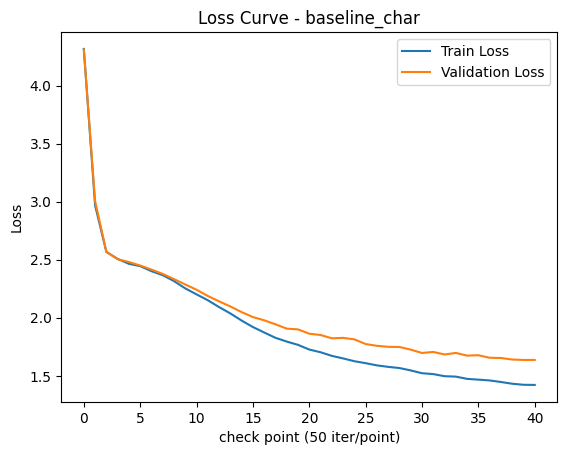

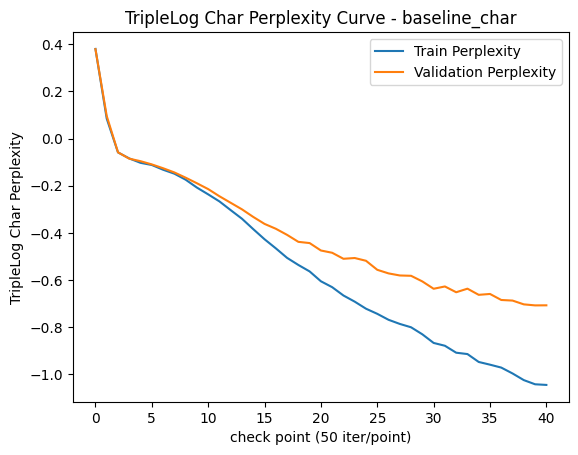

In [ ]:
plot_loss(baseline, "baseline_char")

In [ ]:
baselineTransoformer.to('cpu')
torch.cuda.empty_cache()

# Baseline - SimpleWord Tokenizer

In [ ]:
wordTokenizer = SimpleWordTokenizer(data)
baselineTransoformer = TransformerLM(wordTokenizer.vocab_size, CONTEXT_WINDOW_SIZE).to(device)
baseline_word = ModelTokenizerSystem(baselineTransoformer, wordTokenizer, device, model_name= "baseline_word", optimizer_weight_decay=0)

In [ ]:
baseline_word.train()

  0%|          | 1/2000 [00:07<4:07:37,  7.43s/it]

iteration 0
step 0: train loss 9.4584, val loss 9.4669


 10%|█         | 202/2000 [00:58<49:18,  1.65s/it]  

iteration 200
step 200: train loss 3.5577, val loss 3.6914


 20%|██        | 402/2000 [01:50<43:50,  1.65s/it]  

iteration 400
step 400: train loss 3.3781, val loss 3.5549


 30%|███       | 602/2000 [02:41<38:21,  1.65s/it]

iteration 600
step 600: train loss 3.2822, val loss 3.5015


 40%|████      | 802/2000 [03:32<32:54,  1.65s/it]

iteration 800
step 800: train loss 3.1401, val loss 3.4139


 50%|█████     | 1002/2000 [04:24<27:24,  1.65s/it]

iteration 1000
step 1000: train loss 3.0023, val loss 3.3311


 55%|█████▌    | 1100/2000 [04:49<03:57,  3.79it/s]

Early Stopping Triggered at iteration 1100


In [ ]:
baseline_word.save_model_data()

Model saved to baseline_word/model.pth
Training data saved to baseline_word/baseline_word.json


In [ ]:
print(baseline_word.generate(input_text1))


First Citizen:
Care for us! True, indeed! They ne'er cared for us
yet: suffer us to famish, and their store-houses
crammed with grain; make edicts for usury, to
support usurers; repeal daily any wholesome act
established against the rich, and provide more
piercing statutes daily, to chain up and restrain
the poor. If the wars eat us not up, they will; and
there's all the love they bear us.
And Corn more had put the fortunesnot to makes
Let lives by at better infection; the your whereon
death'Thus herself you made; such on enter,
Affection as him
We trow mine to fly of browprayer;
This in that it in ancient stream the strict malice
Not safeguard swear didst than from fifty,
Which have as Thomas mother my drain that:
Katharina, what he comes he untainted ever
The house our countrymen, ninescore goddess I of him.

EDWARD:
Call silent you, the scaled..

Nurse:
They shall now he more I whereof

CORIOLANUS:
But cost morn;
He are as and see us in some opposers.

KING IV:
The swift command th

In [ ]:
print(baseline_word.generate(input_text2))

MIRANDA:
Why speaks my father so ungently? This
Is the third man that e'er I saw, the first
That e'er I sigh'd for: pity move my father
To be inclined my way!

FERDINAND:
O, if a virgin,
And your affection not gone forth, I'll make you
The queen of Naples.
In stretch'drag services heavens'lessen's the me the dragoned
He' the people the grub, to my so love
In will goes DION: and an allowed friends
In the hour why, us cries,
Armies give the wish't the other.
I was no love, or and my winters
With and good consuls maids, Bolingbroke?
Meaning, scorn cannot craves true her:
To-wilt this death'twas me the ears?
sustain the air both clubs should in work,
And is many trunk the bosom passage, ne'd this world,
About the reckless of of murder'er a bred voices, must
Which and too up, where are 

AUFIDIUS:
Stand brother; were what call fun top-bearer,
The deity well She


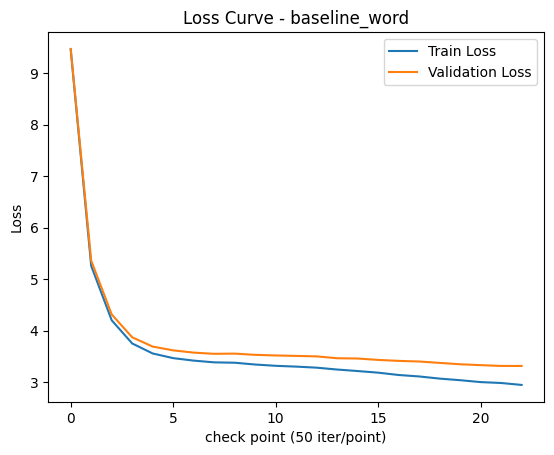

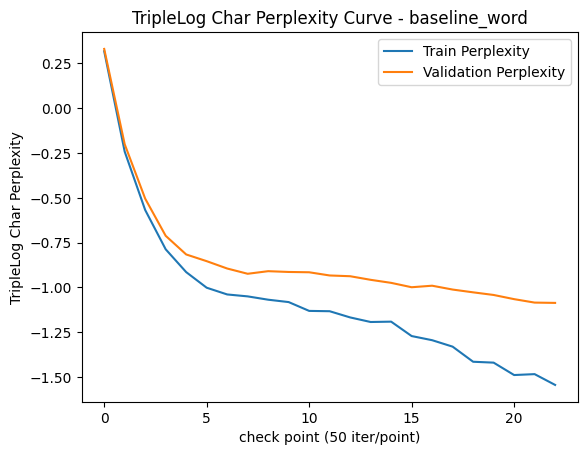

In [ ]:
plot_loss(baseline_word, "baseline_word")

In [ ]:
baselineTransoformer.to('cpu')
torch.cuda.empty_cache()

# Baseline - BPE Tokenizer

In [ ]:
bpeTokenizer = BPETokenizer(data)
baselineTransoformer = TransformerLM(bpeTokenizer.vocab_size, CONTEXT_WINDOW_SIZE).to(device)
baseline_bpe = ModelTokenizerSystem(baselineTransoformer, bpeTokenizer, device, model_name= "baseline_bpe", optimizer_weight_decay=0)

In [ ]:
baseline_bpe.train()

  0%|          | 1/2000 [00:06<3:42:58,  6.69s/it]

iteration 0
step 0: train loss 8.0980, val loss 8.0965


 10%|█         | 201/2000 [00:52<32:32,  1.09s/it]

iteration 200
step 200: train loss 5.2389, val loss 5.2561


 20%|██        | 401/2000 [01:38<28:56,  1.09s/it]

iteration 400
step 400: train loss 4.8067, val loss 4.9333


 30%|███       | 601/2000 [02:24<25:17,  1.08s/it]

iteration 600
step 600: train loss 4.5638, val loss 4.7821


 40%|████      | 801/2000 [03:10<21:41,  1.09s/it]

iteration 800
step 800: train loss 4.3520, val loss 4.6394


 50%|█████     | 1002/2000 [03:56<18:03,  1.09s/it]

iteration 1000
step 1000: train loss 4.1672, val loss 4.5228


 60%|██████    | 1201/2000 [04:42<14:26,  1.09s/it]

iteration 1200
step 1200: train loss 3.9994, val loss 4.4544


 70%|███████   | 1401/2000 [05:28<10:51,  1.09s/it]

iteration 1400
step 1400: train loss 3.8297, val loss 4.3926


 80%|████████  | 1601/2000 [06:13<07:13,  1.09s/it]

iteration 1600
step 1600: train loss 3.6691, val loss 4.3508


 90%|█████████ | 1802/2000 [06:59<03:35,  1.09s/it]

iteration 1800
step 1800: train loss 3.5047, val loss 4.3117


100%|██████████| 2000/2000 [07:45<00:00,  4.30it/s]

iteration 1999
step 1999: train loss 3.3458, val loss 4.3303


In [ ]:
baseline_bpe.save_model_data()

Model saved to baseline_bpe/model.pth
Training data saved to baseline_bpe/baseline_bpe.json


In [ ]:
print(baseline_bpe.generate(input_text1))


First Citizen:
Care for us! True, indeed! They ne'er cared for us
yet: suffer us to famish, and their store-houses
crammed with grain; make edicts for usury, to
support usurers; repeal daily any wholesome act
established against the rich, and provide more
piercing statutes daily, to chain up and restrain
the poor. If the wars eat us not up, they will; and
there's all the love they bear us.

Clown:
I shine sin'sot, and love to make our country's
tester; which shall be directs one of veesues
sasteldondis than an ea dam as we say
hory must be deschanguied: the belly are burest;
And therefore please I see Ros inVERp of it. A boarge us.

First Gentleman:
Look to the wind: if they meet too, but reign:
Comdilenge of the Baptista's own beats
That bred within this which my unth becomes not that.
Let want dishonour'd again.Clown:
What was another murd other faith, being, just
Shice has veery of fellow, would misiences
You met the severity; ever thou wilt, as I hate the
sheleth, haff our makes b

In [ ]:
print(baseline_bpe.generate(input_text2))

MIRANDA:
Why speaks my father so ungently? This
Is the third man that e'er I saw, the first
That e'er I sigh'd for: pity move my father
To be inclined my way!

FERDINAND:
O, if a virgin,
And your affection not gone forth, I'll make you
The queen of Naples.

PRINCE:
Will I did been that would dread to be a truth!
For, that pray him!tis the air!

YORK:
O thou shalt no sooner so great Rivers sheem'd Cay
isting first, I must spare confess.

CLARENCE:
There may I call thee quick in thee.

QUEEN ELIZABETH:
I was deliver'd for fondness,
And the advaffer than thou canst be true.

HENRY BOLINGBROKE:
By love means thou wilt, thou art aid
on beg, tender Clarence to satisfied.

JOHN OFBY:
Why doth I young I life
To drunk, and absent, therefore is spent a countermping:
A prettying from death, disperraresundach,
Put off from a will I hold thee with gentle-night
Forbassower, bold with thy power man
In thy limbs.

RICHARD:
A horse!

KING RICHARD III:
We chooseest thou 'tis conceit as sorrow doth
That 

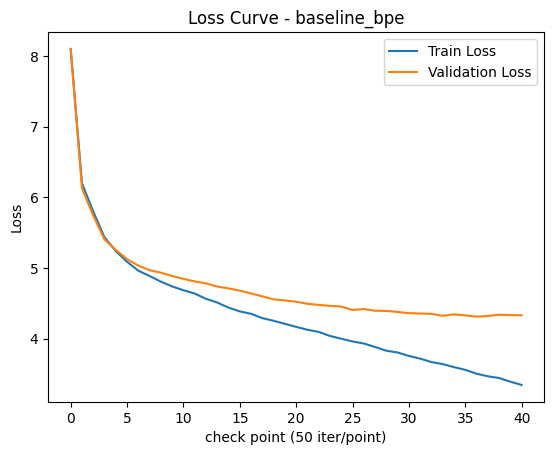

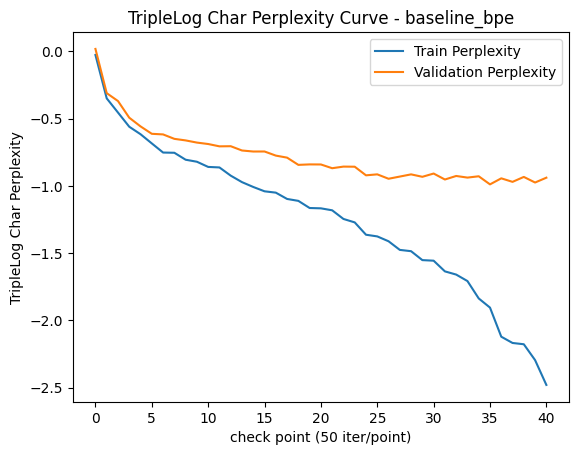

In [ ]:
plot_loss(baseline_bpe, "baseline_bpe")

In [ ]:
baselineTransoformer.to('cpu')
torch.cuda.empty_cache()

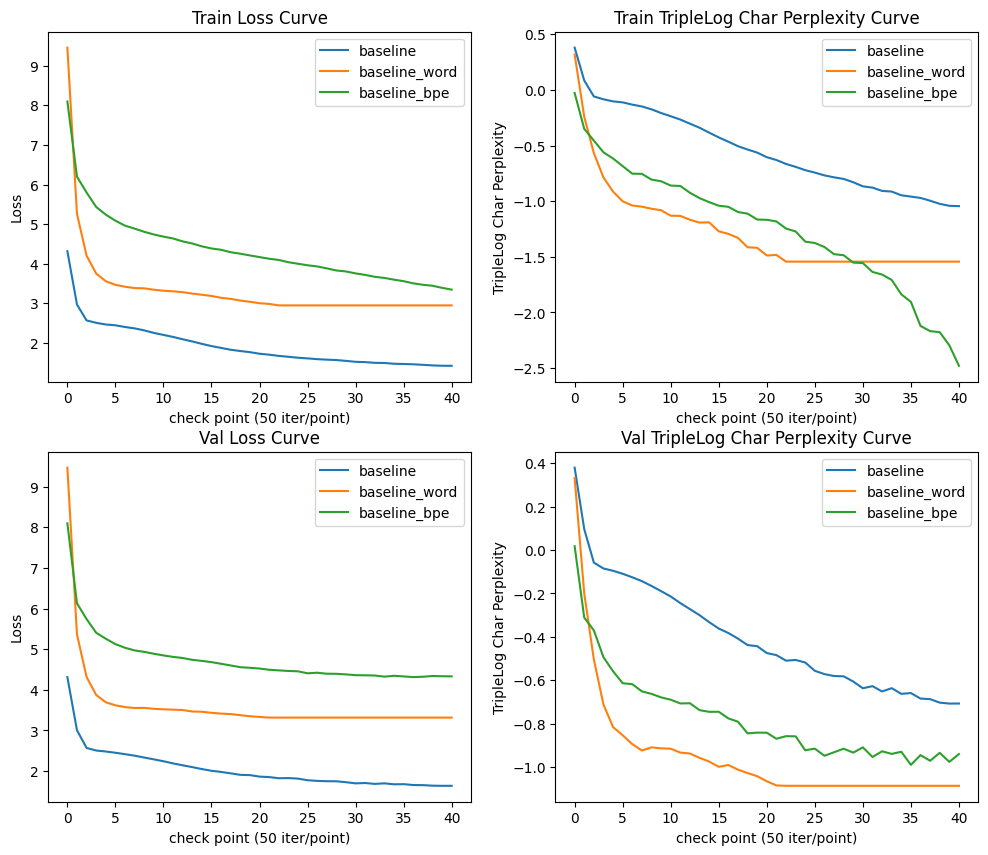

In [ ]:
baseline_list = [baseline, baseline_word, baseline_bpe]
model_name_list = ["baseline", "baseline_word", "baseline_bpe"]
model_compare_plots(baseline_list, model_name_list)

# Applying Rotary Position Embeddings

Char Tokenizer

In [ ]:
charTokenizer = CharacterTokenizer(data)
baselineTransoformer_roe = TransformerLM(charTokenizer.vocab_size, CONTEXT_WINDOW_SIZE, roe = True).to(device)
char_baseline_roe = ModelTokenizerSystem(baselineTransoformer_roe, charTokenizer, device, model_name= "char_baseline_roe", optimizer_weight_decay=0)

In [ ]:
char_baseline_roe.train()
char_baseline_roe.save_model_data()

  0%|          | 3/2000 [00:04<35:23,  1.06s/it]  

iteration 0
step 0: train loss 4.2823, val loss 4.2818


 10%|█         | 203/2000 [00:30<13:58,  2.14it/s]

iteration 200
step 200: train loss 1.9796, val loss 2.0289


 20%|██        | 403/2000 [00:57<12:18,  2.16it/s]

iteration 400
step 400: train loss 1.6004, val loss 1.7478


 30%|███       | 603/2000 [01:23<10:47,  2.16it/s]

iteration 600
step 600: train loss 1.4762, val loss 1.6453


 40%|████      | 803/2000 [01:50<09:13,  2.16it/s]

iteration 800
step 800: train loss 1.3922, val loss 1.5823


 50%|█████     | 1003/2000 [02:17<07:41,  2.16it/s]

iteration 1000
step 1000: train loss 1.3308, val loss 1.5572


 60%|██████    | 1203/2000 [02:43<06:08,  2.16it/s]

iteration 1200
step 1200: train loss 1.2895, val loss 1.5290


 70%|███████   | 1403/2000 [03:10<04:35,  2.16it/s]

iteration 1400
step 1400: train loss 1.2583, val loss 1.5115


 80%|████████  | 1603/2000 [03:36<03:05,  2.14it/s]

iteration 1600
step 1600: train loss 1.2339, val loss 1.4951


 82%|████████▎ | 1650/2000 [03:43<00:47,  7.38it/s]

Early Stopping Triggered at iteration 1650
Model saved to char_baseline_roe_RoE/model.pth
Training data saved to char_baseline_roe_RoE/char_baseline_roe.json


In [ ]:
print(char_baseline_roe.generate(input_text1))


First Citizen:
Care for us! True, indeed! They ne'er cared for us
yet: suffer us to famish, and their store-houses
crammed with grain; make edicts for usury, to
support usurers; repeal daily any wholesome act
established against the rich, and provide more
piercing statutes daily, to chain up and restrain
the poor. If the wars eat us not up, they will; and
there's all the love they bear us.

EDWARD:
I thalour with no look'd
No moder in sicker to me.

LUCIO:
You slip of honour, million prince;
So faction little staps a monatter too?

First Citizen:
Who is youth! Mark, why say.

Provost:
'QUEEN MARGANE:
Very it taken'd by with a gallad here,
Un


In [ ]:
print(char_baseline_roe.generate(input_text2))

MIRANDA:
Why speaks my father so ungently? This
Is the third man that e'er I saw, the first
That e'er I sigh'd for: pity move my father
To be inclined my way!

FERDINAND:
O, if a virgin,
And your affection not gone forth, I'll make you
The queen of Naples.

MILLIURENCENTIO:
O, sir, you will.

ROMAS:
We tender you, make you? that it scarriages
TRPansoon son?  Tybalt? fare you to thek?
Peer task its for this? a, who lasted you I,
Thus lay under out myself: let you pleasing,
That curses, how from Edward with re


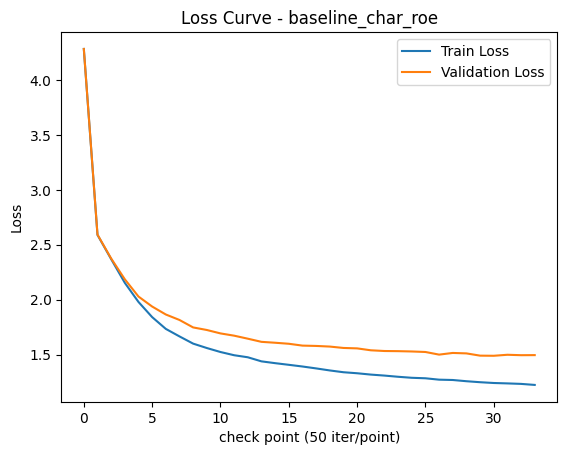

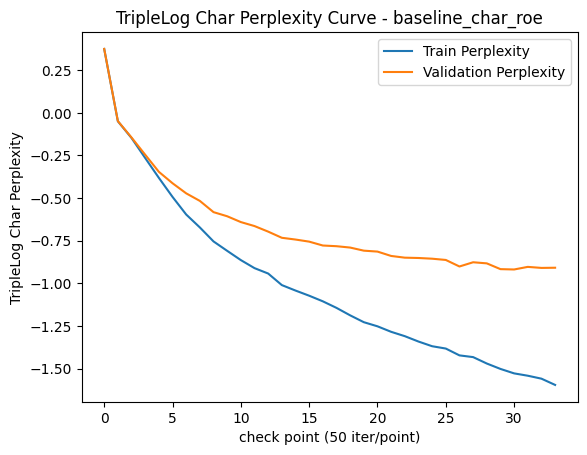

In [ ]:
plot_loss(char_baseline_roe, "baseline_char_roe")

In [ ]:
baselineTransoformer_roe.to('cpu')
torch.cuda.empty_cache()

----------------------------

Word Tokenizer

In [ ]:
wordTokenizer = SimpleWordTokenizer(data)
baselineTransoformer_roe = TransformerLM(wordTokenizer.vocab_size, CONTEXT_WINDOW_SIZE, roe = True).to(device)
word_baseline_roe = ModelTokenizerSystem(baselineTransoformer_roe, wordTokenizer, device, model_name= "word_baseline_roe", optimizer_weight_decay=0)

In [ ]:
word_baseline_roe.train()
word_baseline_roe.save_model_data()

  0%|          | 3/2000 [00:05<44:53,  1.35s/it]  

iteration 0
step 0: train loss 9.8084, val loss 9.7961


 10%|█         | 203/2000 [00:39<17:40,  1.69it/s]

iteration 200
step 200: train loss 3.4330, val loss 3.5807


 20%|██        | 403/2000 [01:13<15:43,  1.69it/s]

iteration 400
step 400: train loss 3.0579, val loss 3.2917


 30%|███       | 603/2000 [01:47<13:44,  1.69it/s]

iteration 600
step 600: train loss 2.8113, val loss 3.1573


 38%|███▊      | 750/2000 [02:13<03:42,  5.63it/s]

Early Stopping Triggered at iteration 750
Model saved to word_baseline_roe_RoE/model.pth
Training data saved to word_baseline_roe_RoE/word_baseline_roe.json


In [ ]:
print(word_baseline_roe.generate(input_text1))


First Citizen:
Care for us! True, indeed! They ne'er cared for us
yet: suffer us to famish, and their store-houses
crammed with grain; make edicts for usury, to
support usurers; repeal daily any wholesome act
established against the rich, and provide more
piercing statutes daily, to chain up and restrain
the poor. If the wars eat us not up, they will; and
there's all the love they bear us.
Committed
With pity, fourteen.

peril.will go;
undeck hither. Gremio, counsel:
My life only title and your Io will be breaker:
And felony before question'd in the Injurious conquerors:
Banish'years: bare foundation, one of our doings:
Then forthcoming ghostly last, devise glorious meantime by should sleep,
But or than down peace;--due of leaf' and dotard
I'll were a gin.

; fulfill's sorrow as blame it:
Were cried 'fraughting, upon charity.effusion:
How dies the confirmed hatme Paulina and most most
Likely; all the Infused added men.
If youTo the people's of catching four!
Awayart not master, which 

In [ ]:
print(word_baseline_roe.generate(input_text2))

MIRANDA:
Why speaks my father so ungently? This
Is the third man that e'er I saw, the first
That e'er I sigh'd for: pity move my father
To be inclined my way!

FERDINAND:
O, if a virgin,
And your affection not gone forth, I'll make you
The queen of Naples.
Safe:
We may see saying duck, but on off by designs?
The people's idle abhorr'
To hear his lecture as of defence;
Set upon the Listen than their adversaries,
A judgment's streak'd;
Best the town Duke, Roman, where
To hostages sweet feather'd higher press;
Or let the chamber of two replenishedIt is Menenius?

Third C:
dishonourableskins our Placentio yours, who fairly and embracements,
So with bestowintents, and perish the rails, why ghosts's lovest
distinguished of great butterflies, switch to franchises,
Ethiopian, why from speech. By half scripture, frown comeThoughts
You are Claudio.

minion OF AUMERLE:
But bared upon wooes
Look; jewel which shall the rest from his occasion!

ROMEO


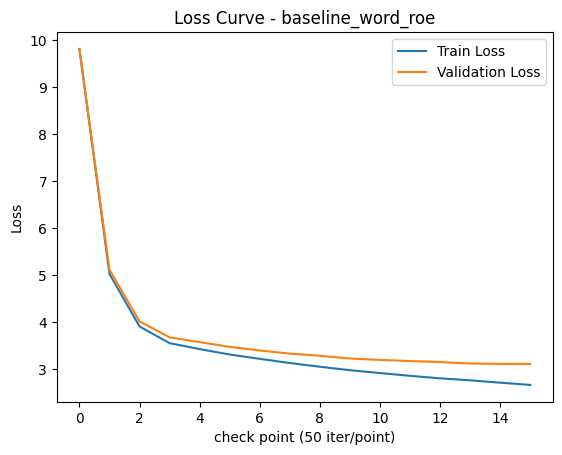

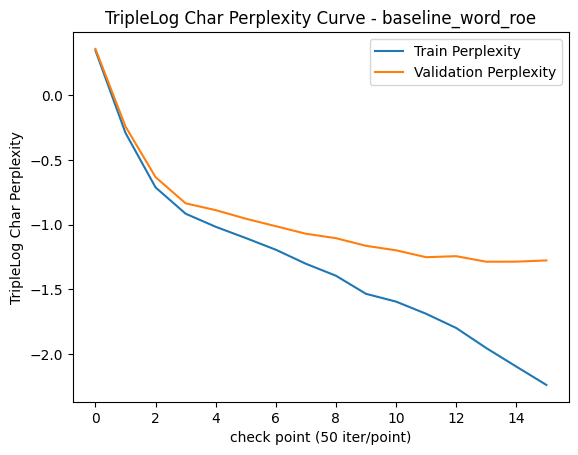

In [ ]:
plot_loss(word_baseline_roe, "baseline_word_roe")

In [ ]:
baselineTransoformer_roe.to('cpu')
torch.cuda.empty_cache()

---------------------------------------------------------------

BPE Tokenizer

In [ ]:
bpeTokenizer = BPETokenizer(data)
baselineTransoformer_roe = TransformerLM(bpeTokenizer.vocab_size, CONTEXT_WINDOW_SIZE, roe = True).to(device)
bpe_baseline_roe = ModelTokenizerSystem(baselineTransoformer_roe, bpeTokenizer, device, model_name= "bpe_baseline_roe", optimizer_weight_decay=0)

In [ ]:
bpe_baseline_roe.train()
bpe_baseline_roe.save_model_data()

  0%|          | 3/2000 [00:04<38:11,  1.15s/it]  

iteration 0
step 0: train loss 8.0380, val loss 8.0303


 10%|█         | 203/2000 [00:33<14:56,  2.01it/s]

iteration 200
step 200: train loss 4.7720, val loss 4.9082


 20%|██        | 403/2000 [01:01<13:17,  2.00it/s]

iteration 400
step 400: train loss 4.1603, val loss 4.5259


 30%|███       | 603/2000 [01:30<11:36,  2.00it/s]

iteration 600
step 600: train loss 3.7557, val loss 4.3883


 40%|████      | 803/2000 [01:58<10:02,  1.99it/s]

iteration 800
step 800: train loss 3.4027, val loss 4.3489


 50%|█████     | 1003/2000 [02:27<08:17,  2.00it/s]

iteration 1000
step 1000: train loss 3.0661, val loss 4.4037


 60%|██████    | 1203/2000 [02:56<06:38,  2.00it/s]

iteration 1200
step 1200: train loss 2.7437, val loss 4.4976


 70%|███████   | 1403/2000 [03:24<04:58,  2.00it/s]

iteration 1400
step 1400: train loss 2.4402, val loss 4.6171


 80%|████████  | 1603/2000 [03:53<03:18,  2.00it/s]

iteration 1600
step 1600: train loss 2.1234, val loss 4.7589


 90%|█████████ | 1803/2000 [04:22<01:38,  2.00it/s]

iteration 1800
step 1800: train loss 1.8576, val loss 4.9305


100%|██████████| 2000/2000 [04:50<00:00,  6.88it/s]

iteration 1999
step 1999: train loss 1.6093, val loss 5.0806
Model saved to bpe_baseline_roe_RoE/model.pth
Training data saved to bpe_baseline_roe_RoE/bpe_baseline_roe.json


In [ ]:
print(bpe_baseline_roe.generate(input_text1))


First Citizen:
Care for us! True, indeed! They ne'er cared for us
yet: suffer us to famish, and their store-houses
crammed with grain; make edicts for usury, to
support usurers; repeal daily any wholesome act
established against the rich, and provide more
piercing statutes daily, to chain up and restrain
the poor. If the wars eat us not up, they will; and
there's all the love they bear us.

AUTOLYCUS:
Believe them, an beseech you, sir, inemaction.

MOPSA:
I have still bail, blessed both, and beyond too much prepicious
still by the confirmation. If any was the dog home born
teen drugeaches at the first untilous footing too, your
poor-sAy; no be inimes call wear upon the
dictress.

In more:
But do not discover God for no
 less goodness stell. But best or if it be not M Richmond,
I' the rage like of your lady: my repay'd
Nay to me the ground I knew, that rob-fbeians
Mine these very paids; any most seemers will
tend thee to thy part there: I dare not for you.

Shepherd:
Come, sir, your go

In [ ]:
print(bpe_baseline_roe.generate(input_text2))

MIRANDA:
Why speaks my father so ungently? This
Is the third man that e'er I saw, the first
That e'er I sigh'd for: pity move my father
To be inclined my way!

FERDINAND:
O, if a virgin,
And your affection not gone forth, I'll make you
The queen of Naples.

Girl:
Good uncle, I beseech you:
What news, my lord?

DION:
My lord, my rap Kate sickicily! I cannot speak.

DUKE VINCENTIO:
He'll take most fit for your good will,
Cheard me ere save; and when do not very cloud
Rienry you should to sit in a fever,
Lest his so suppet gave me a grace,
But quake his press sold.

PAULINA:
Procumstant enough about me
There's no man again.

DUKE VINCENTIO:
True;
You'll be less than your service that loves me,
I may not weep your daughter.

ESCALUS:
I would they were as guideER court-in lord,
Let me like her sisters have been suspicion.

ISABELLA:
You may agerleag that pil full wondrous!
Tell not me how I came chances;
And yet I knew doth first becomes me
Is for my face I dare not live.

MARIANA:
Well sai

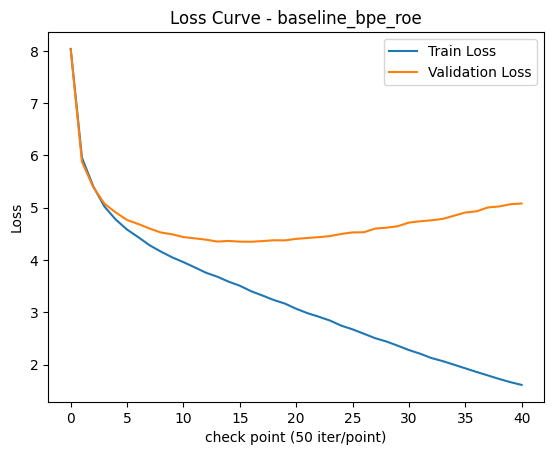

<ipython-input-21-bfc42f216a99>:10: RuntimeWarning: invalid value encountered in log
  plt.plot(np.log(np.log(np.log(model_system.char_perplexities_train_val["train"]))), label="Train Perplexity")


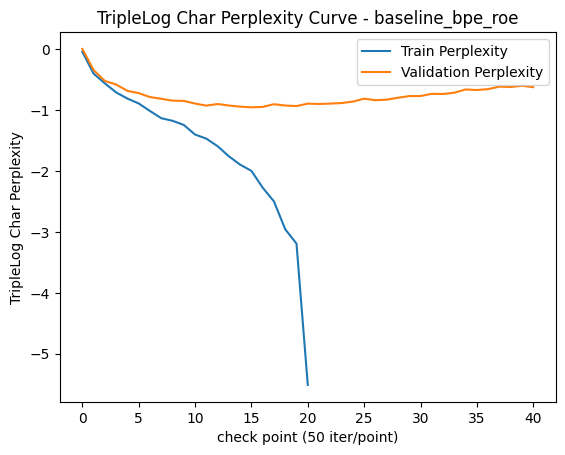

In [ ]:
plot_loss(bpe_baseline_roe, "baseline_bpe_roe")

In [ ]:
baselineTransoformer_roe.to('cpu')
torch.cuda.empty_cache()

------------------------------------------

<ipython-input-22-37bd8822dbc4>:26: RuntimeWarning: invalid value encountered in log
  axes[axis_x, axis_y].plot(np.log(np.log(np.log(model_system.char_perplexities_train_val[name]))), label= model_name)


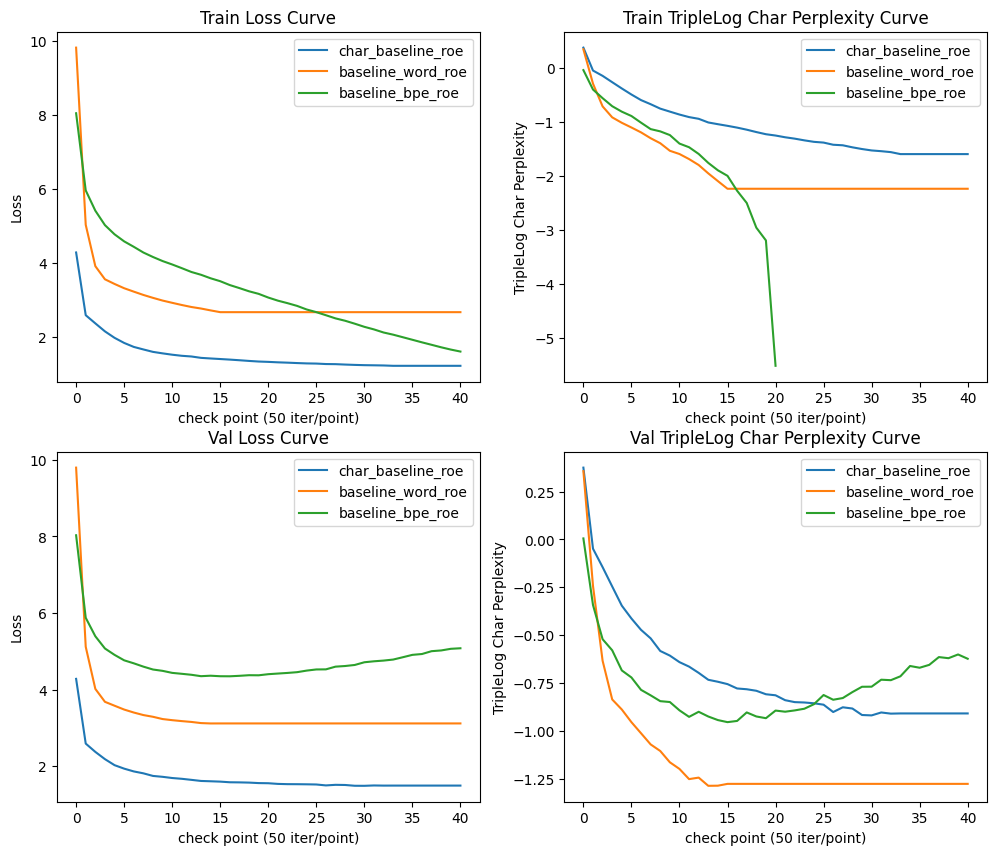

In [ ]:
baseline_list_roe = [char_baseline_roe, word_baseline_roe, bpe_baseline_roe]
model_name_list_roe = ["char_baseline_roe", "baseline_word_roe", "baseline_bpe_roe"]
model_compare_plots(baseline_list_roe, model_name_list_roe)

# Applying Reg & Gelu

Char Tokenizer

In [ ]:
charTokenizer = CharacterTokenizer(data)
baselineTransoformer_regelu = TransformerLM(charTokenizer.vocab_size, CONTEXT_WINDOW_SIZE, gelu= True, dropout=True, rmsnorm=True).to(device)
char_baseline_regelu = ModelTokenizerSystem(baselineTransoformer_regelu, charTokenizer, device, model_name= "char_baseline_regelu")

In [ ]:
char_baseline_regelu.train()
char_baseline_regelu.save_model_data()

  0%|          | 1/2000 [00:06<3:39:01,  6.57s/it]

iteration 0
step 0: train loss 4.2157, val loss 4.2142


 10%|█         | 201/2000 [00:51<31:31,  1.05s/it]

iteration 200
step 200: train loss 2.5073, val loss 2.5109


 20%|██        | 401/2000 [01:36<28:00,  1.05s/it]

iteration 400
step 400: train loss 2.4167, val loss 2.4228


 30%|███       | 601/2000 [02:21<24:30,  1.05s/it]

iteration 600
step 600: train loss 2.2275, val loss 2.2504


 40%|████      | 801/2000 [03:06<21:00,  1.05s/it]

iteration 800
step 800: train loss 2.0433, val loss 2.1076


 50%|█████     | 1001/2000 [03:51<17:34,  1.06s/it]

iteration 1000
step 1000: train loss 1.9016, val loss 2.0007


 60%|██████    | 1201/2000 [04:36<13:59,  1.05s/it]

iteration 1200
step 1200: train loss 1.7761, val loss 1.9097


 70%|███████   | 1402/2000 [05:21<10:28,  1.05s/it]

iteration 1400
step 1400: train loss 1.6969, val loss 1.8626


 80%|████████  | 1602/2000 [06:06<06:58,  1.05s/it]

iteration 1600
step 1600: train loss 1.6320, val loss 1.8087


 90%|█████████ | 1802/2000 [06:51<03:28,  1.05s/it]

iteration 1800
step 1800: train loss 1.5785, val loss 1.7616


100%|██████████| 2000/2000 [07:35<00:00,  4.39it/s]

iteration 1999
step 1999: train loss 1.5295, val loss 1.7288
Model saved to char_baseline_regelu_RMSNorm_GELU_Dropout_wd0.01/model.pth
Training data saved to char_baseline_regelu_RMSNorm_GELU_Dropout_wd0.01/char_baseline_regelu.json


In [ ]:
print(char_baseline_regelu.generate(input_text1))


First Citizen:
Care for us! True, indeed! They ne'er cared for us
yet: suffer us to famish, and their store-houses
crammed with grain; make edicts for usury, to
support usurers; repeal daily any wholesome act
established against the rich, and provide more
piercing statutes daily, to chain up and restrain
the poor. If the wars eat us not up, they will; and
there's all the love they bear us.

ANOLONT:
I siritht: day, so do neted sither; bUng so,
Thet; thou for in your is absiec not yeiers not!
Blojear:
Is should so much is my kilong to seech: I should
The too this feellieger: all so, a son deftend to armay.

GRUS:
It the so vollain hath malst 


In [ ]:
print(char_baseline_regelu.generate(input_text2))

MIRANDA:
Why speaks my father so ungently? This
Is the third man that e'er I saw, the first
That e'er I sigh'd for: pity move my father
To be inclined my way!

FERDINAND:
O, if a virgin,
And your affection not gone forth, I'll make you
The queen of Naples.

ISABELABHA;
There in to the dune.

WARWICK:
And it thank offenerance:
As him guild his curthas to mream presomet, adming to done
Preation off your livest so noble would
Spats, thou, as streep dives pupsen
O him cruphsmanden at by orop-purhrow
His langer'd


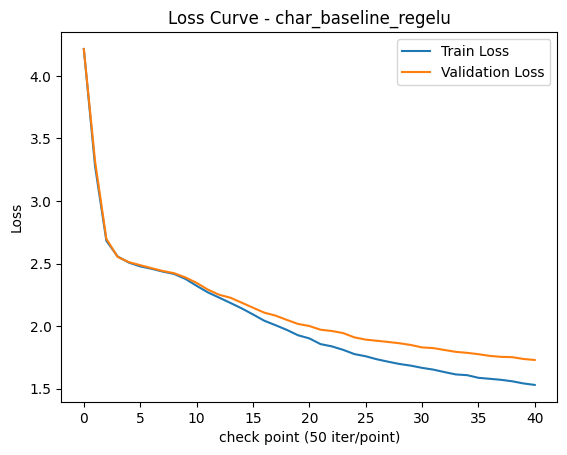

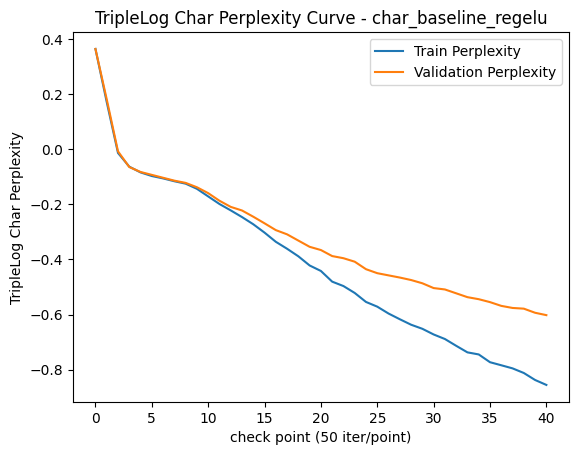

In [ ]:
plot_loss(char_baseline_regelu, "char_baseline_regelu")

In [ ]:
baselineTransoformer_regelu.to('cpu')
torch.cuda.empty_cache()

-------------------------------------------------------

Word Tokenizer

In [ ]:
wordTokenizer = SimpleWordTokenizer(data)
baselineTransoformer_regelu = TransformerLM(wordTokenizer.vocab_size, CONTEXT_WINDOW_SIZE, gelu= True, dropout=True, rmsnorm=True).to(device)
word_baseline_regelu = ModelTokenizerSystem(baselineTransoformer_regelu, wordTokenizer, device, model_name= "word_baseline_regelu")

In [ ]:
word_baseline_regelu.train()
word_baseline_regelu.save_model_data()

  0%|          | 2/2000 [00:07<1:45:16,  3.16s/it]

iteration 0
step 0: train loss 9.7415, val loss 9.7283


 10%|█         | 202/2000 [01:00<50:01,  1.67s/it]  

iteration 200
step 200: train loss 3.5700, val loss 3.7063


 20%|██        | 402/2000 [01:52<44:27,  1.67s/it]  

iteration 400
step 400: train loss 3.3732, val loss 3.5610


 30%|███       | 602/2000 [02:45<38:56,  1.67s/it]

iteration 600
step 600: train loss 3.2809, val loss 3.5021


 40%|████      | 802/2000 [03:38<33:20,  1.67s/it]

iteration 800
step 800: train loss 3.1814, val loss 3.4614


 50%|█████     | 1002/2000 [04:30<27:46,  1.67s/it]

iteration 1000
step 1000: train loss 3.0795, val loss 3.4051


 60%|██████    | 1202/2000 [05:23<22:16,  1.67s/it]

iteration 1200
step 1200: train loss 2.9514, val loss 3.3341


 70%|███████   | 1402/2000 [06:15<16:38,  1.67s/it]

iteration 1400
step 1400: train loss 2.8256, val loss 3.2633


 80%|████████  | 1602/2000 [07:08<11:04,  1.67s/it]

iteration 1600
step 1600: train loss 2.7090, val loss 3.2430


 90%|█████████ | 1802/2000 [08:01<05:30,  1.67s/it]

iteration 1800
step 1800: train loss 2.6056, val loss 3.2318


100%|██████████| 2000/2000 [08:53<00:00,  3.75it/s]

iteration 1999
step 1999: train loss 2.5172, val loss 3.2332


Model saved to word_baseline_regelu_RMSNorm_GELU_Dropout_wd0.01/model.pth
Training data saved to word_baseline_regelu_RMSNorm_GELU_Dropout_wd0.01/word_baseline_regelu.json


In [ ]:
print(word_baseline_regelu.generate(input_text1))


First Citizen:
Care for us! True, indeed! They ne'er cared for us
yet: suffer us to famish, and their store-houses
crammed with grain; make edicts for usury, to
support usurers; repeal daily any wholesome act
established against the rich, and provide more
piercing statutes daily, to chain up and restrain
the poor. If the wars eat us not up, they will; and
there's all the love they bear us.
You'Menenius there't?maw charm'?
Then cast stopp'reflect !folly!

Tybalt?nointed Juliet,
The boy that,
Into that fail'our boys Julietfellest sad five headed life,
Should pile? does come impudently invocate murdering castleHold!
Erroneous than yond child's in maids,
hent the nose him: 's a breath
The woman to the field, that I hereby,
His law hath keep't a wife: a woman,
Since son the of a fish, perhaps
I find a fens, that should have come to.
How she, thou are hanged in thy flesh;
Give us.

BIONDELLO:
O, thy nurse, Juliet for the good doubt!

First Servingman:
Marry, I'endure that not.

LUCIO:
Is no

In [ ]:
print(word_baseline_regelu.generate(input_text2))

MIRANDA:
Why speaks my father so ungently? This
Is the third man that e'er I saw, the first
That e'er I sigh'd for: pity move my father
To be inclined my way!

FERDINAND:
O, if a virgin,
And your affection not gone forth, I'll make you
The queen of Naples.
Stab Advantaging? ropes! Love sound'dangerously couldst't?
Be herb justice anon? may away those point:
So rule, Fortune's? think the's little friar;
Before the time's Edward's is from Rome,
The pride approach: but she kill the trumpets upon.
Where shall the promotions for the happy well.

creation:
Not shall follow'd our news:
Give not the seas to you: see your victories in honour:
Than in the sorrow seal, expedition, in him to't,
Speak, was: 'Tis plucker his name, and under brow
After the encountering, received, methinks revoke
And state, in the streets farther; in enthralled
To inventory before the chaff! you have
Where is thus lean the 


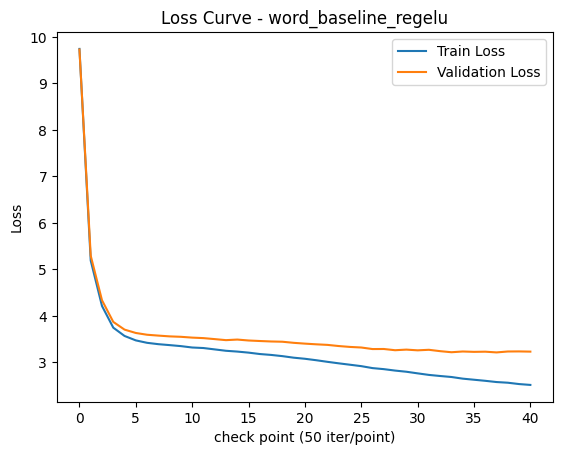

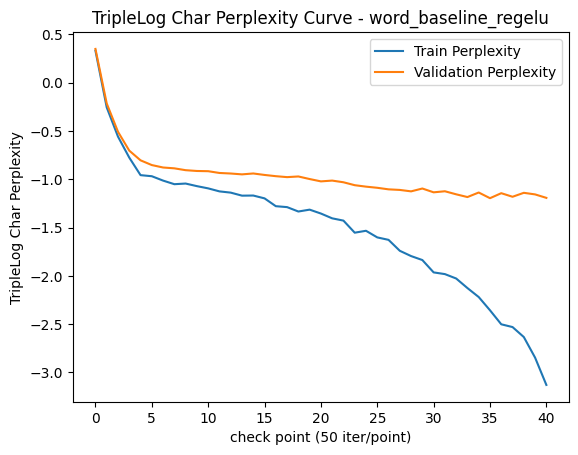

In [ ]:
plot_loss(word_baseline_regelu, "word_baseline_regelu")

In [ ]:
baselineTransoformer_regelu.to('cpu')
torch.cuda.empty_cache()

---------------------------------------------------------------------

BPE Tokenizer

In [ ]:
bpeTokenizer = BPETokenizer(data)
baselineTransoformer_regelu = TransformerLM(bpeTokenizer.vocab_size, CONTEXT_WINDOW_SIZE, gelu= True, dropout=True, rmsnorm=True).to(device)
bpe_baseline_regelu = ModelTokenizerSystem(baselineTransoformer_regelu, bpeTokenizer, device, model_name= "bpe_baseline_regelu")

In [ ]:
bpe_baseline_regelu.train()
bpe_baseline_regelu.save_model_data()

  0%|          | 1/2000 [00:06<3:46:55,  6.81s/it]

iteration 0
step 0: train loss 8.0992, val loss 8.1047


 10%|█         | 202/2000 [00:53<44:53,  1.50s/it]  

iteration 200
step 200: train loss 5.3526, val loss 5.3513


 20%|██        | 402/2000 [01:41<40:03,  1.50s/it]

iteration 400
step 400: train loss 4.8832, val loss 4.9576


 30%|███       | 602/2000 [02:28<35:06,  1.51s/it]

iteration 600
step 600: train loss 4.6816, val loss 4.8458


 40%|████      | 802/2000 [03:15<28:41,  1.44s/it]

iteration 800
step 800: train loss 4.5041, val loss 4.7500


 50%|█████     | 1002/2000 [04:02<25:02,  1.51s/it]

iteration 1000
step 1000: train loss 4.3309, val loss 4.6373


 60%|██████    | 1202/2000 [04:49<20:01,  1.51s/it]

iteration 1200
step 1200: train loss 4.1940, val loss 4.5388


 70%|███████   | 1402/2000 [05:36<13:16,  1.33s/it]

iteration 1400
step 1400: train loss 4.0446, val loss 4.4663


 80%|████████  | 1600/2000 [06:23<01:35,  4.17it/s]

Early Stopping Triggered at iteration 1600
Model saved to bpe_baseline_regelu_RMSNorm_GELU_Dropout_wd0.01/model.pth
Training data saved to bpe_baseline_regelu_RMSNorm_GELU_Dropout_wd0.01/bpe_baseline_regelu.json


In [ ]:
print(bpe_baseline_regelu.generate(input_text1))


First Citizen:
Care for us! True, indeed! They ne'er cared for us
yet: suffer us to famish, and their store-houses
crammed with grain; make edicts for usury, to
support usurers; repeal daily any wholesome act
established against the rich, and provide more
piercing statutes daily, to chain up and restrain
the poor. If the wars eat us not up, they will; and
there's all the love they bear us.

SICINIUS:
You will haveARHOR who'll prove that, and.

BRUTUS all thee last;
not shall be virtness of Antulation.
Have I can you twace; but Rome,
st note to to return, parted Cth,
Such thus thriveing courtm please his
for the most as honour: sit
tholding a little I must seem
the ca pleasant. Aulans that love of me found, I would
wmorrow from his meeted.

BRUTUS:
Jessenger being like deed!

CAMILLO:
I'll tell this.

CORIOLANUS:
Welcome, my good matter at serve slunt, it is good
lown not.

SICINIUS:
Wherein me?
 consul God!
Either we'll finds are, my speech doth told.

Bel general; come with thy repdg

In [ ]:
print(bpe_baseline_regelu.generate(input_text2))

MIRANDA:
Why speaks my father so ungently? This
Is the third man that e'er I saw, the first
That e'er I sigh'd for: pity move my father
To be inclined my way!

FERDINAND:
O, if a virgin,
And your affection not gone forth, I'll make you
The queen of Naples.

RICHARD:
No bite him, sweet news a ritities name:
Unb is a one accusant i' the second eyes,
Whose distitots banish' the way, if the bed
He the roverth simjohn a mournnd-pen
With the thought of men and want work
Boss thousand sentenceing of black sights son!
And, then, nowks, secret love Romeo know,
I must bid the right. accomas night, traitor and recell Rome,
Fildenge me stoer their hours; a dream's bed reck
A bawd affest the vowous head;
'Twice is I could be entep sople,
Be open to a rumand to abw you. Come, Themption are tail
The king and foolas you to prison,
LeableI'll things in offomrits
From thisRIVERS:
Here when I come to give him to prest well. Waway;
Or the queen is how made me holds captazle,
And I'll no more to immiced th

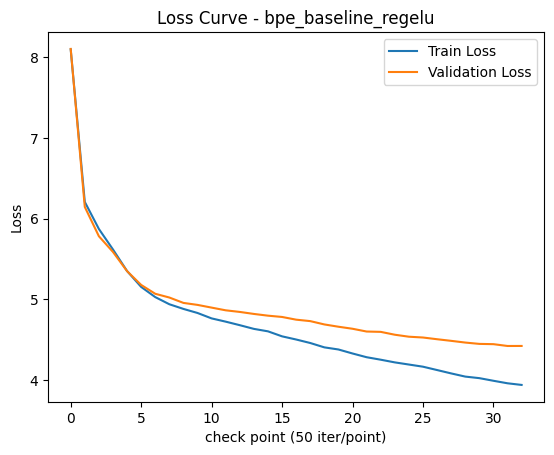

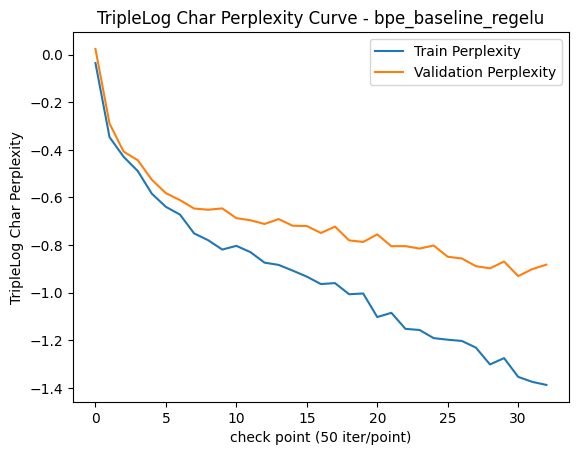

In [ ]:
plot_loss(bpe_baseline_regelu, "bpe_baseline_regelu")

In [ ]:
baselineTransoformer_regelu.to('cpu')
torch.cuda.empty_cache()

---------------------------------------------------------

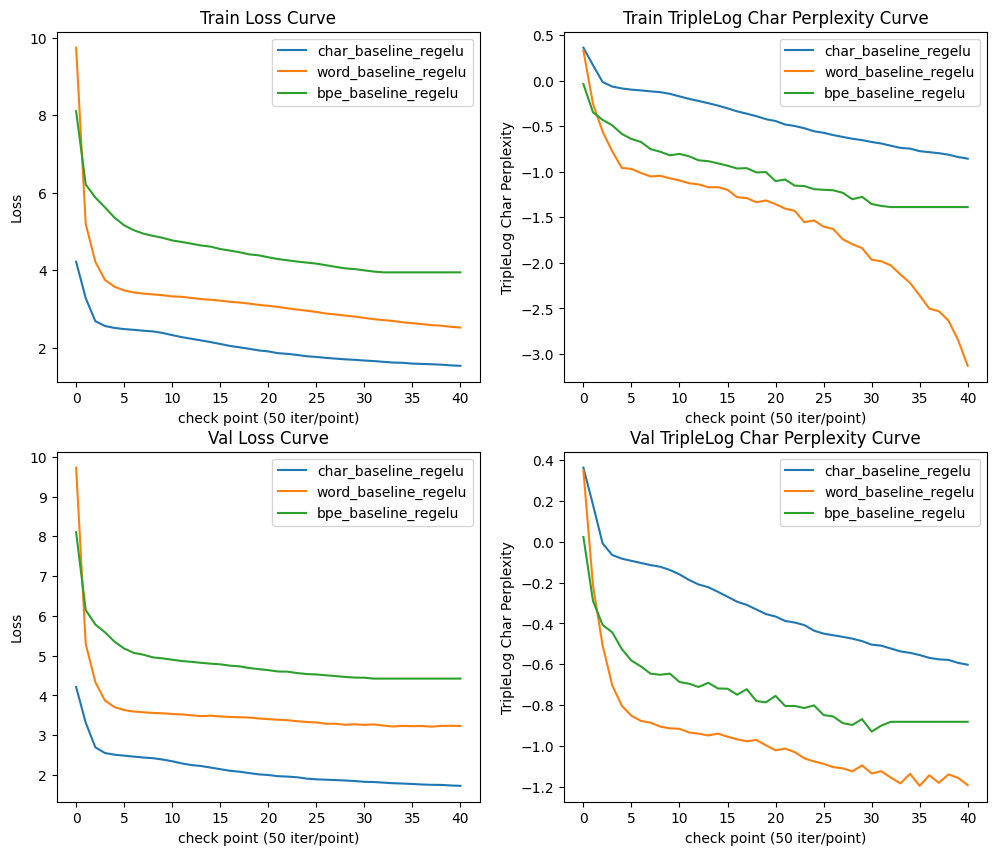

In [ ]:
baseline_list_regelu = [char_baseline_regelu, word_baseline_regelu, bpe_baseline_regelu]
model_name_list_regelu = ["char_baseline_regelu", "word_baseline_regelu", "bpe_baseline_regelu"]
model_compare_plots(baseline_list_regelu, model_name_list_regelu)

# Full Models - Reg & GELU & RPoE

Char Tokenizer

In [ ]:
charTokenizer = CharacterTokenizer(data)
FullTransoformer = TransformerLM(charTokenizer.vocab_size, CONTEXT_WINDOW_SIZE, gelu= True, dropout=True, rmsnorm=True, roe= True).to(device)
char_full = ModelTokenizerSystem(FullTransoformer, charTokenizer, device, model_name= "char_full")

In [ ]:
char_full.train()
char_full.save_model_data()

  0%|          | 3/2000 [00:04<36:08,  1.09s/it]  

iteration 0
step 0: train loss 4.1258, val loss 4.1301


 10%|█         | 203/2000 [00:31<14:14,  2.10it/s]

iteration 200
step 200: train loss 2.1822, val loss 2.2069


 20%|██        | 403/2000 [00:59<12:41,  2.10it/s]

iteration 400
step 400: train loss 1.8657, val loss 1.9561


 30%|███       | 603/2000 [01:27<11:04,  2.10it/s]

iteration 600
step 600: train loss 1.6789, val loss 1.8306


 40%|████      | 803/2000 [01:55<09:29,  2.10it/s]

iteration 800
step 800: train loss 1.5577, val loss 1.7481


 50%|█████     | 1000/2000 [02:22<02:22,  7.01it/s]

Early Stopping Triggered at iteration 1000
Model saved to char_full_RoE_RMSNorm_GELU_Dropout_wd0.01/model.pth
Training data saved to char_full_RoE_RMSNorm_GELU_Dropout_wd0.01/char_full.json


In [ ]:
print(char_full.generate(input_text1))


First Citizen:
Care for us! True, indeed! They ne'er cared for us
yet: suffer us to famish, and their store-houses
crammed with grain; make edicts for usury, to
support usurers; repeal daily any wholesome act
established against the rich, and provide more
piercing statutes daily, to chain up and restrain
the poor. If the wars eat us not up, they will; and
there's all the love they bear us.

LANGY:
He shame a hour lady.

DUKE OF YORKE:
Noble us our all sir:
Deter the instout of anoble have cends within-ment;
For their diest the will goed affider.

LEONTES:
Nour hath say my lord, and all graciounce,
Than this did was to son thy some his rupon;


In [ ]:
print(char_full.generate(input_text2))

MIRANDA:
Why speaks my father so ungently? This
Is the third man that e'er I saw, the first
That e'er I sigh'd for: pity move my father
To be inclined my way!

FERDINAND:
O, if a virgin,
And your affection not gone forth, I'll make you
The queen of Naples.
Can the made his warreway yours, soo?
Horty and brother if tale, griant thing time?

KING Lafe?
If I ard in Horrain; and show untreas the live let the grast.
I not--other, wrual let this sward bear must,
way say the man's countrence; and she rows
Dook lare


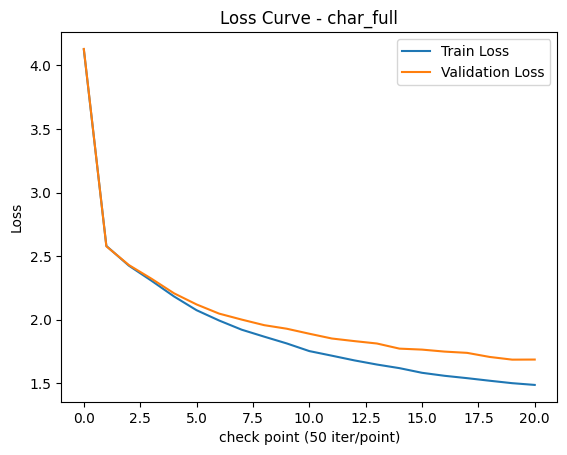

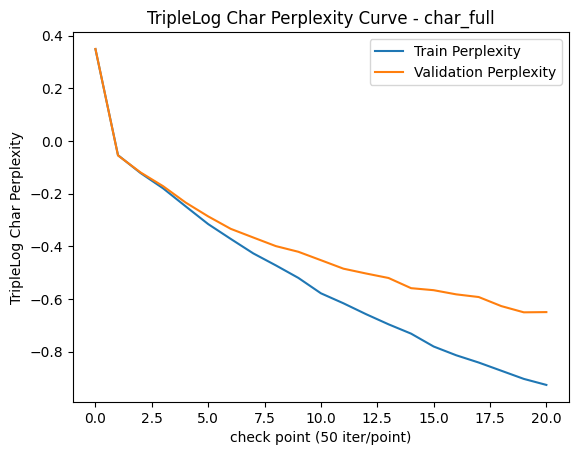

In [ ]:
plot_loss(char_full, "char_full")

In [ ]:
baselineTransoformer_regelu.to('cpu')
torch.cuda.empty_cache()

------------------------------------------------------------------

Word Tokenizer

In [ ]:
wordTokenizer = SimpleWordTokenizer(data)
FullTransoformer = TransformerLM(wordTokenizer.vocab_size, CONTEXT_WINDOW_SIZE, gelu= True, dropout=True, rmsnorm=True, roe= True).to(device)
word_full = ModelTokenizerSystem(FullTransoformer, wordTokenizer, device, model_name= "word_full")

In [ ]:
word_full.train()
word_full.save_model_data()

  0%|          | 3/2000 [00:05<45:42,  1.37s/it]  

iteration 0
step 0: train loss 9.7389, val loss 9.7326


 10%|█         | 203/2000 [00:40<18:01,  1.66it/s]

iteration 200
step 200: train loss 3.4556, val loss 3.5992


 20%|██        | 403/2000 [01:15<16:00,  1.66it/s]

iteration 400
step 400: train loss 3.1384, val loss 3.3511


 30%|███       | 603/2000 [01:51<14:01,  1.66it/s]

iteration 600
step 600: train loss 2.9103, val loss 3.2094


 40%|████      | 803/2000 [02:26<12:02,  1.66it/s]

iteration 800
step 800: train loss 2.7523, val loss 3.1429


 48%|████▊     | 950/2000 [02:52<03:10,  5.50it/s]

Early Stopping Triggered at iteration 950


Model saved to word_full_RoE_RMSNorm_GELU_Dropout_wd0.01/model.pth
Training data saved to word_full_RoE_RMSNorm_GELU_Dropout_wd0.01/word_full.json


In [ ]:
print(word_full.generate(input_text1))


First Citizen:
Care for us! True, indeed! They ne'er cared for us
yet: suffer us to famish, and their store-houses
crammed with grain; make edicts for usury, to
support usurers; repeal daily any wholesome act
established against the rich, and provide more
piercing statutes daily, to chain up and restrain
the poor. If the wars eat us not up, they will; and
there's all the love they bear us.
sound no more fault: Death,
With Further desert power by unknown summer.
Her roe! Where I and heap

SICINIUS:
O upright heart, and pardon him dwell for along.

Friars:
And and Hastings, he is their creation presumption.

CAMILLO:
Has mine duty and looks have neglected in little,
This hundred bed-temptation for his regiment combating
Upon the other Dry his power how
Now hie her weapons to him up. Why, was to will
Whom signal as the lowest clapping such shameful gentle nobler,
An unrest'd to, hers, and Arabia,
For an shipboard between he.

ESCALUS:
Three blister's tunes.
On heath at wrath; but if he d

In [ ]:
print(word_full.generate(input_text2))

MIRANDA:
Why speaks my father so ungently? This
Is the third man that e'er I saw, the first
That e'er I sigh'd for: pity move my father
To be inclined my way!

FERDINAND:
O, if a virgin,
And your affection not gone forth, I'll make you
The queen of Naples.
moveables and the prince, whom I kill King Yet,
Who office Mowbray and lame shame.

Nurse:
PERDITA:
The gentlewoman as her the strongest legs honours
To assay's throne stray: finish direct thy queen
Will advocate so corse: the law, I do ne'er
Yet be appear and the BOLINGBROKE:
True, it O, that Henry come withbenefactors their
More maids Clarence thinks in the garland of her,
And ne'twas legs to apparel you would add inexorable.
O, battles the
Bum, ne'tis pale finger ye, do now court.

GRUMIO:
She is hid eye, but much for one wrong,
Her tall was as honest for your own.

HENRY BOLINGBROKE:
Marry, gentle for the sanctity,
Unto you


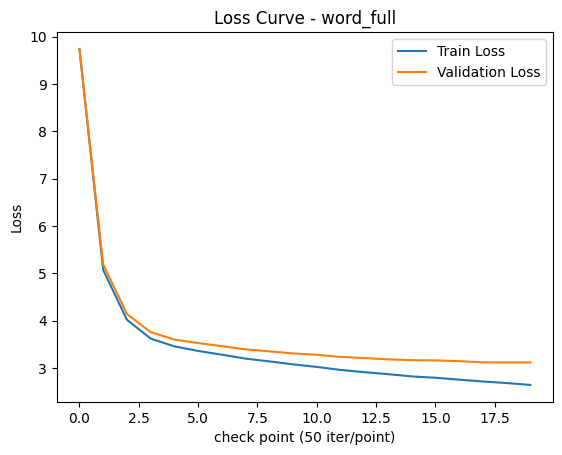

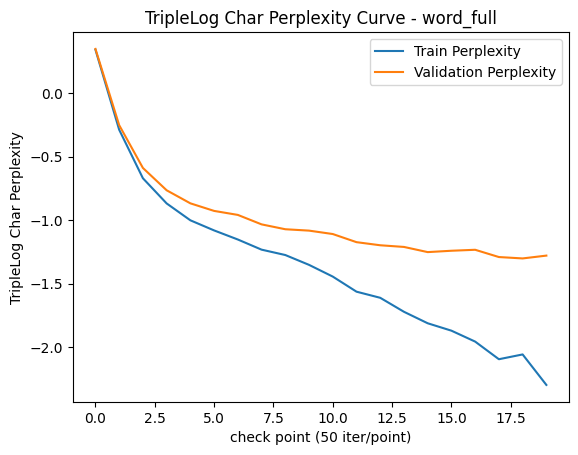

In [ ]:
plot_loss(word_full, "word_full")

In [ ]:
baselineTransoformer_regelu.to('cpu')
torch.cuda.empty_cache()

------------------------------------------------------------------

BPE Tokenizer

In [ ]:
bpeTokenizer = BPETokenizer(data)
FullTransoformer = TransformerLM(bpeTokenizer.vocab_size, CONTEXT_WINDOW_SIZE, gelu= True, dropout=True, rmsnorm=True, roe= True).to(device)
bpe_full = ModelTokenizerSystem(FullTransoformer, bpeTokenizer, device, model_name= "bpe_full")

In [ ]:
bpe_full.train()
bpe_full.save_model_data()

  0%|          | 3/2000 [00:04<38:41,  1.16s/it]  

iteration 0
step 0: train loss 8.0768, val loss 8.0807


 10%|█         | 203/2000 [00:34<15:18,  1.96it/s]

iteration 200
step 200: train loss 4.8720, val loss 4.9320


 20%|██        | 403/2000 [01:03<13:37,  1.95it/s]

iteration 400
step 400: train loss 4.3378, val loss 4.5828


 30%|███       | 603/2000 [01:33<11:54,  1.96it/s]

iteration 600
step 600: train loss 4.0210, val loss 4.4023


 40%|████      | 803/2000 [02:03<10:12,  1.96it/s]

iteration 800
step 800: train loss 3.7622, val loss 4.3085


 48%|████▊     | 950/2000 [02:25<02:40,  6.53it/s]

Early Stopping Triggered at iteration 950
Model saved to bpe_full_RoE_RMSNorm_GELU_Dropout_wd0.01/model.pth
Training data saved to bpe_full_RoE_RMSNorm_GELU_Dropout_wd0.01/bpe_full.json


In [ ]:
print(bpe_full.generate(input_text1))


First Citizen:
Care for us! True, indeed! They ne'er cared for us
yet: suffer us to famish, and their store-houses
crammed with grain; make edicts for usury, to
support usurers; repeal daily any wholesome act
established against the rich, and provide more
piercing statutes daily, to chain up and restrain
the poor. If the wars eat us not up, they will; and
there's all the love they bear us.

EL:
Sings he hath sleepen us;: Iiful
d enough with n themctors here in the rest thus.

Third Citizen:
How much the owners ta'y the officer blood
her being forerity, which perpumber vowed hence.

ICHMOND:
I have all to go; 'tis agree are you
And so dulls: the city hereBe well to show themisf
To pert them. Thou art him deny the world;
Men that us obstiharch at the tongues
Nor do requution I'll witness to the voices:
The advice that the people is pace Stanth,
Comzed ground we more than beating: in thisLAN tail
Rock, your you haveth to arms to this business
Give the beholding prince.

LUCIO:
Be wiseToH

In [ ]:
print(bpe_full.generate(input_text2))

MIRANDA:
Why speaks my father so ungently? This
Is the third man that e'er I saw, the first
That e'er I sigh'd for: pity move my father
To be inclined my way!

FERDINAND:
O, if a virgin,
And your affection not gone forth, I'll make you
The queen of Naples.

RIVERS:
Now please you, the field, now Edward purpose.
It is twenty post inhily enterm, York
Of authority of her father' grief to his person.

RESSThere needs comes now here in the niss of him
He women do him abhus about it.

JULIET:
Conspier  Grumio, or; hath no more for the
The parleen for rob, the day, the form the greater good
Are walked up to thee therefore unto her.

FSpETER:
How toner his house to him and proof:
He must heaved in mine eyes, but therein
Of thine full comfort, Mless are not prophen'd
Insed and count of come, let me think,
Unwring this colours, in peace abroad and war
A prisoner of hot prince.
M spent, lords, as much seanscent
More agreey disgem their stLike night,
Were but rails to the very eyes of my labour
Bu

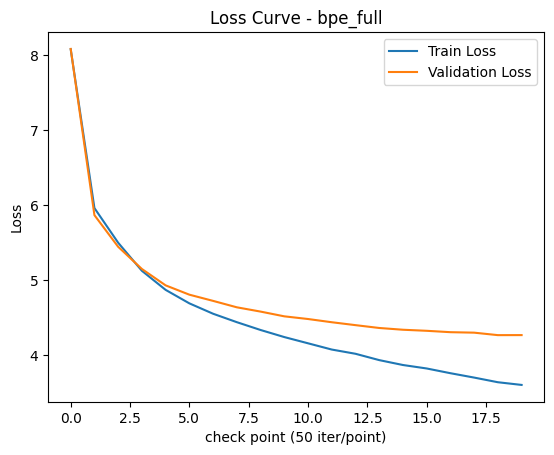

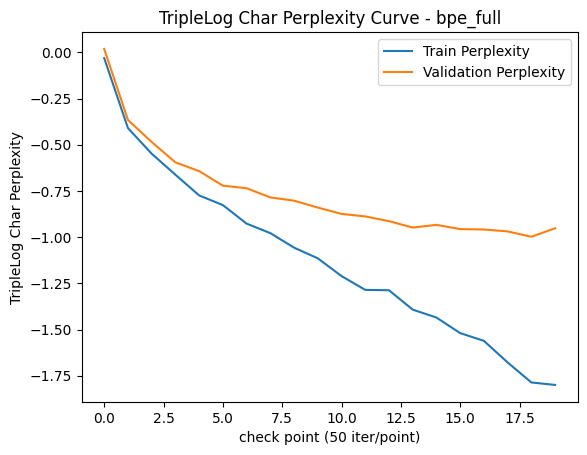

In [ ]:
plot_loss(bpe_full, "bpe_full")

In [ ]:
baselineTransoformer_regelu.to('cpu')
torch.cuda.empty_cache()

--------------------------------------------------------------------------------

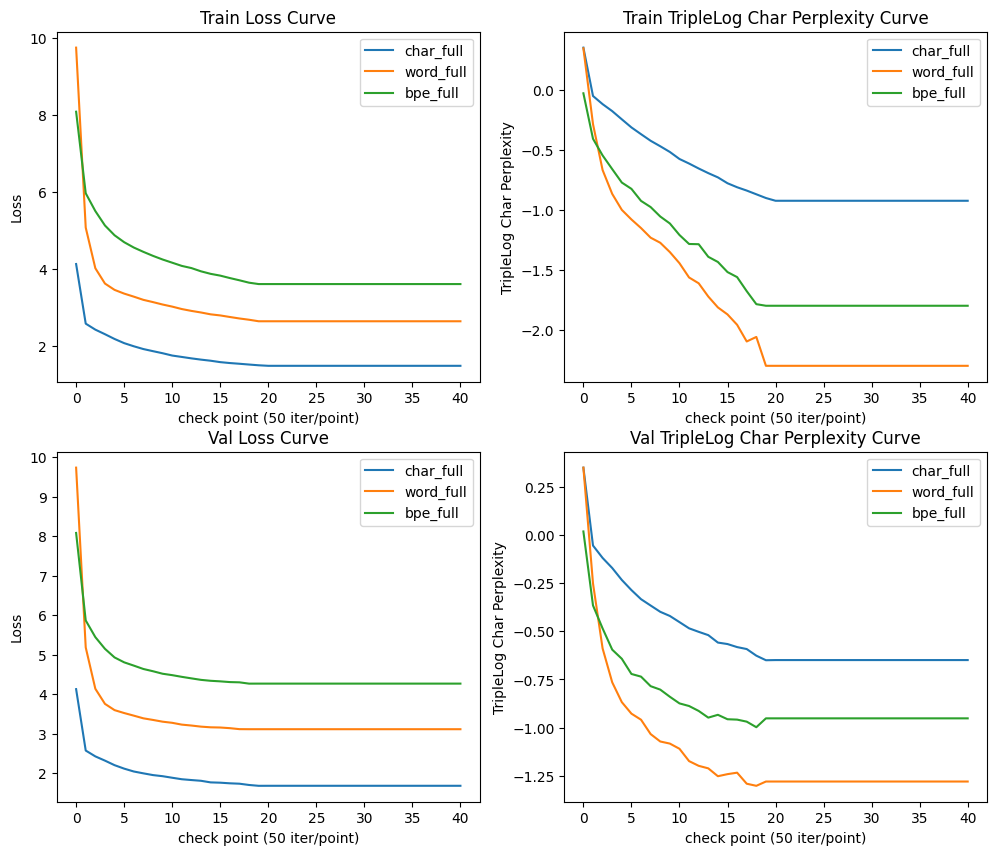

In [ ]:
full_list = [char_full, word_full, bpe_full]
model_name_list_full = ["char_full", "word_full", "bpe_full"]
model_compare_plots(full_list, model_name_list_full)

# Tokenizer & [Baseline, Baseline_roe, Baseline_regule, Full] Compare

### Char Tokenizer

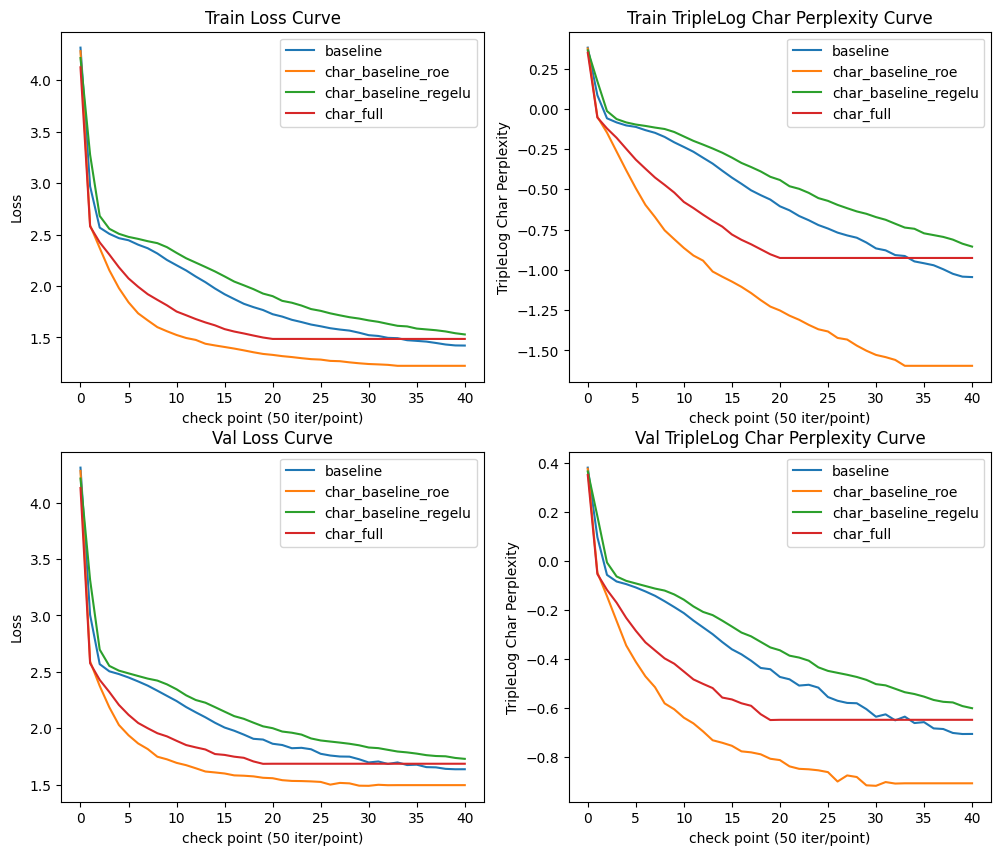

In [ ]:
char_list = [baseline, char_baseline_roe, char_baseline_regelu, char_full]
model_name_list_char = ["baseline","char_baseline_roe", "char_baseline_regelu", "char_full"]
model_compare_plots(char_list, model_name_list_char)

### Word Tokenizer

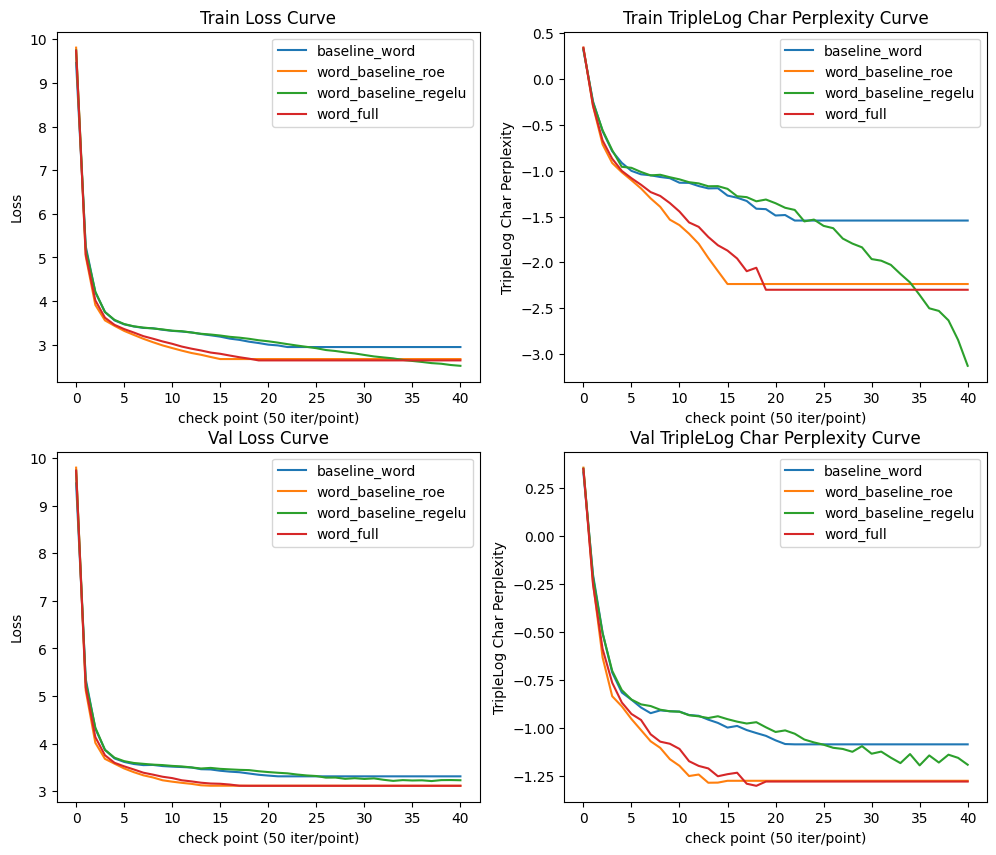

In [ ]:
word_list = [baseline_word, word_baseline_roe, word_baseline_regelu, word_full]
model_name_list_word = ["baseline_word", "word_baseline_roe", "word_baseline_regelu", "word_full"]
model_compare_plots(word_list, model_name_list_word)

### BPE Tokenizer

<ipython-input-22-37bd8822dbc4>:26: RuntimeWarning: invalid value encountered in log
  axes[axis_x, axis_y].plot(np.log(np.log(np.log(model_system.char_perplexities_train_val[name]))), label= model_name)


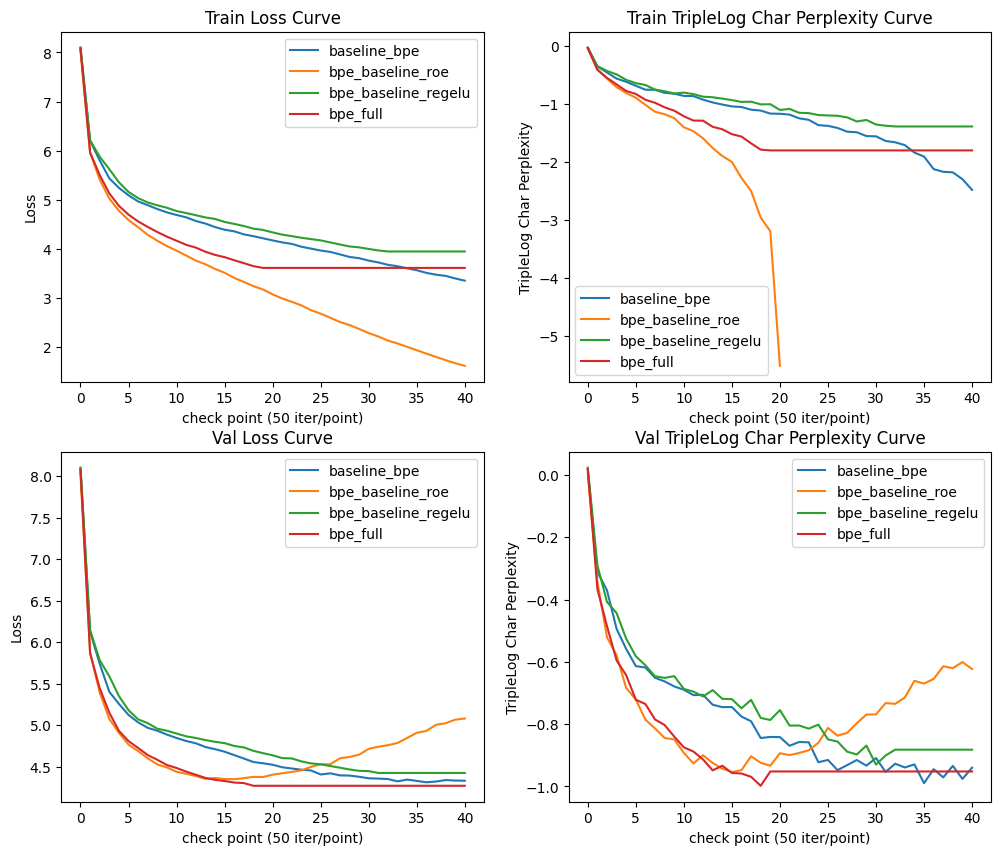

In [ ]:
bpe_list = [baseline_bpe, bpe_baseline_roe, bpe_baseline_regelu, bpe_full]
model_name_list_bpe = ["baseline_bpe", "bpe_baseline_roe", "bpe_baseline_regelu", "bpe_full"]
model_compare_plots(bpe_list, model_name_list_bpe)

### Baseline (Char Tokenizer) vs Full (Char, Word, BPE)

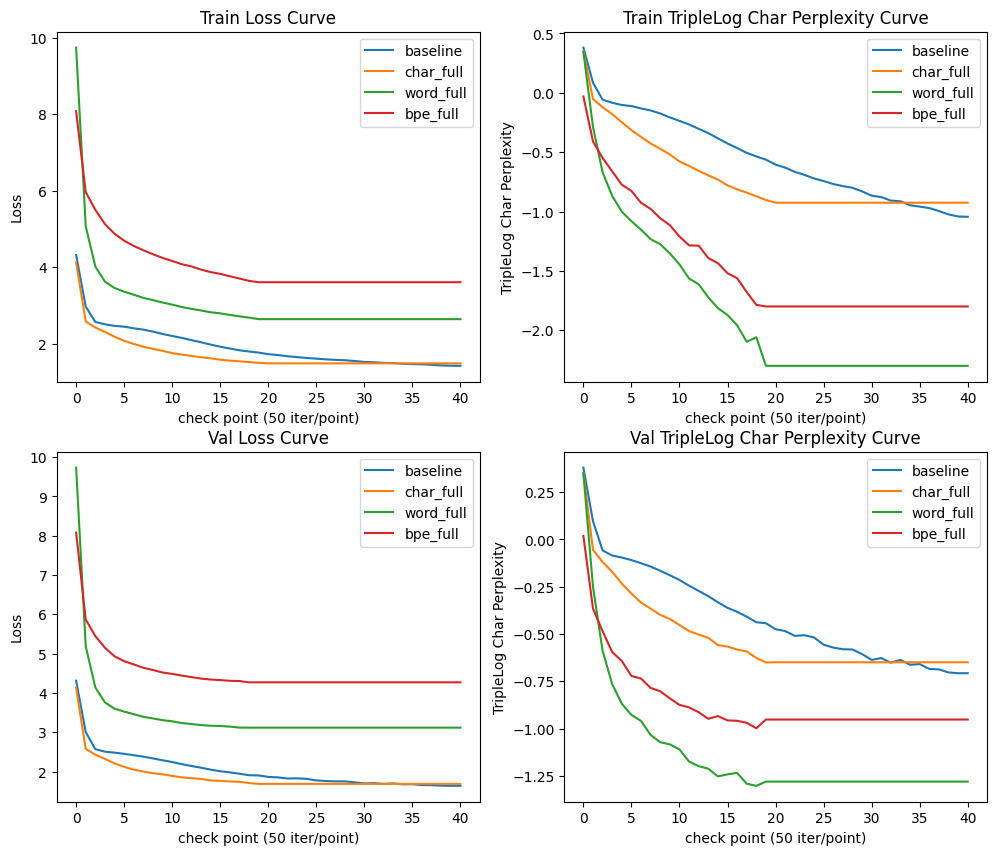

In [ ]:
final_list = [baseline, char_full, word_full, bpe_full]
model_name_list_final = ["baseline", "char_full", "word_full", "bpe_full"]
model_compare_plots(final_list, model_name_list_final)

# Combining

In [38]:
import os
import json
import matplotlib.pyplot as plt
import numpy as np

In [39]:
tokenizer_names = ["char", "word", "bpe"]
train_val = ['train', "val"]
data = {}

for filename in os.listdir("/content/"):
    # Check if the filename contains any of the specified keywords
    for name in tokenizer_names:
        if name in filename and filename.endswith(".json"):
            filepath = os.path.join("/content/", filename)
            with open(filepath, "r", encoding="utf-8") as f:
                data[filename[:-5]] = json.load(f)

In [40]:
model_names = list(data.keys())
model_names.sort()
model_names

['bpe_baseline',
 'bpe_baseline_regelu',
 'bpe_baseline_roe',
 'bpe_full',
 'char_baseline',
 'char_baseline_regelu',
 'char_baseline_roe',
 'char_full',
 'word_baseline',
 'word_baseline_regelu',
 'word_baseline_roe',
 'word_full']

<ipython-input-75-bdcf7f93aeb7>:8: RuntimeWarning: invalid value encountered in log
  plot_data = np.log(np.log(np.log(np.array(data[modelname]["char_perplexities_train_val"][name]))))


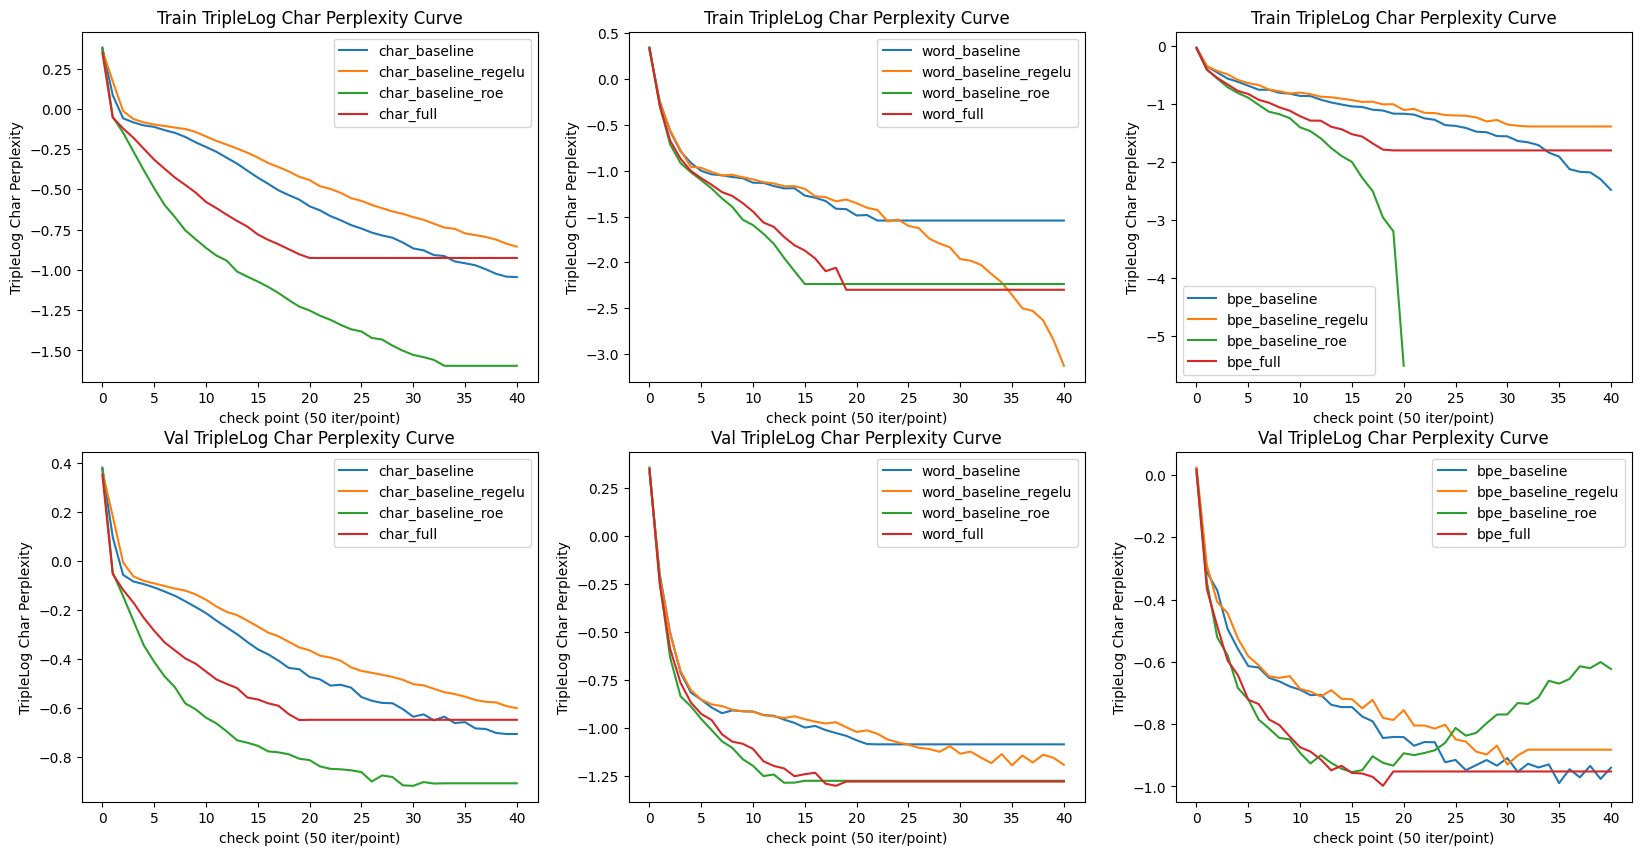

In [75]:
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
max_len = 41
axis_x, axis_y = 0, 0 # plot axis
for name in train_val:
  for tk_name in tokenizer_names:
    for modelname in model_names:
      if tk_name in modelname:
        plot_data = np.log(np.log(np.log(np.array(data[modelname]["char_perplexities_train_val"][name]))))
        if len(plot_data) < max_len:
          extend_len = max_len - len(plot_data)
          plot_data = np.concatenate([plot_data, np.array([plot_data[-1]] * extend_len, dtype=plot_data.dtype)])
        axes[axis_x, axis_y].plot(plot_data, label= modelname)
    axes[axis_x, axis_y].set_xlabel('check point (50 iter/point)')
    axes[axis_x, axis_y].set_ylabel('TripleLog Char Perplexity')
    axes[axis_x, axis_y].set_title(name.capitalize() + ' TripleLog Char Perplexity Curve')
    axes[axis_x, axis_y].legend()
    axis_y += 1
  axis_x += 1
  axis_y = 0